In [286]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy import integrate
from scipy import special
from scipy import optimize
#from scipy import trapz # trapz 函数将在scipy2.0中被移除，并归入np函数中
from numpy import trapz
import time
from joblib import Parallel, delayed
from scipy import interpolate

import pandas as pd

from pylab import *
from matplotlib.font_manager import FontProperties 
mpl.rcParams['font.sans-serif'] = ['SimHei'] 

plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [288]:
global A_v 
A_v = 3e5
global  Q_rad_man_initial
Q_rad_man_initial = 8.86999180e+11#
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 120e-9

In [290]:
vis_ratio = 2

In [292]:
Q_rad_core_intial = 4861841326.886071

In [294]:
R = 1737e3 #m 月球直径
R_c =  350e3 #m  月核直径
M_e = 7.3477e22 #Kg  来源 维基百科
G = 6.77e-11   
c_c =  675  #core's specific  heat capacity
c_m = 1300  # ！！！！！！取地球值
X_s = 7.0  # wt % 硫元素的质量分数，对应的摩尔分数约为 0.79
          
#X_s = 0.0
s_yr = 3600*24*365 
alpha_0_c = 4e-5 #！！对于不同行星似乎一致
T_sol0 = 1244
A = 4*math.pi*R**2
Em_kappa = 1e-6
Em_rho_solid = 3300
T_s = 275
L_melt = 320e3 #J/kg




D_s =  0.5#硫元素的固液分配系数！！！！！！可改
X_s_sol = 2/(1+D_s)*X_s
rho_Fe = 6980 #H21 eq8
rho_s = 1819

mu_0 = 4*math.pi*1e-7 # H/m   vacuum permeability

In [296]:
mu_vef = v_0  #!!!地球情况 !!!!!D14 里为5e7  ！！！数量级的不同在于公式存在单位制换算
#A_v = 3e5 #！！这个参数对月幔温度结构影响很大！！！！！！！！！！！值该怎么取？？

#A_v = 1.5e5  #Scheinberg 2015
T_ref = 1600#K
R_g = 8.3144 
T_surf = 300


k_0 = 3.3 #w/m/k
Ra_crit = 660
mass_mantel = 7.236226894229513e+22
rad_scal = 1/30
tau_rad = 2.9e9*s_yr
tau_rad_core = 1.2e9*s_yr

In [297]:
#mass_man/4.06e24*

In [299]:
area_e = 4.*math.pi*R**2.                   #[m^2] E surface area.
area_cmb = 4.*math.pi*R_c**2
alpha_0_c = 4e-5

s_yr = 3600.*24*365
t_end = 4.5e9*s_yr
dt = 1e6*s_yr
t_0 = 0
nt = int((t_end-t_0)/dt)+1
t_t  = np.linspace(t_0 , t_end , nt)


In [300]:
#!!!!!!!审稿人三提到的文章
Cth = 33.9e-9
CU  = Cth/3.78
CK = CU*3030



U238_in = 0.9927*CU*9.17e-5
U235_in = 0.0072*CU*5.75e-4
Th232_in = Cth*2.56e-5
K40_in = 1.17e-4*CK*2.97e-5

Q_rad_in = (U238_in+U235_in+Th232_in+K40_in)*mass_mantel

Q_rad_man1 = (U238_in*np.exp(np.log(2)*-t_t/s_yr/4.46e9)+U235_in*np.exp(np.log(2)*-t_t/s_yr/7.04e8) 
        +Th232_in*np.exp(np.log(2)*-t_t/s_yr/1.4e10)+K40_in*np.exp(np.log(2)*-t_t/s_yr/1.26e9) )*mass_mantel


In [303]:
CTh_in = 110e-9
CTh_today = CTh_in*np.exp(-4.2e9/1.4e10)
CTh_today

8.149000427498897e-08

In [305]:
CTh_today= 74e-9
CTh_in = CTh_today/np.exp(-4.5e9/1.4e10) 
CTh_in

1.0205314067553884e-07

In [306]:
CTh_today= 56e-9
CTh_in = CTh_today/np.exp(-4.5e9/1.4e10) 
CTh_in

7.722940375446183e-08

In [308]:
CTh_today_tian = 4.5e-6/43.9
CTh_in_tian = CTh_today_tian/np.exp(-4e9/1.4e10) 
CTh_in_tian 

1.3640557832603814e-07

In [309]:
# 计算放射性生热
def Q_radman(t ):
    CTh_in = C_Th_in
    CTh_today = CTh_in*np.exp(-4e9/1.4e10)
    CU  = CTh_today/3.78
    CK = CU*3030

    #计算初始放射性生热元素含量
    
    CU238_in = 0.9927*CU/np.exp(-4e9/4.46e9) 
    CU235_in = 0.0072*CU/np.exp(-4e9/7.04e8)
    CK40_in = 1.17e-4*CK/np.exp(-4e9/1.26e9)

    #计算生热
    Q_rad_man = (CU238_in*np.exp(-t*np.log(2)/s_yr/4.46e9)*9.17e-5+CU235_in*np.exp(-t*np.log(2)/s_yr/7.04e8)*5.75e-4 
        +CTh_in*np.exp(-t*np.log(2)/s_yr/1.4e10)*2.56e-5+CK40_in*np.exp(-t*np.log(2)/s_yr/1.26e9)*2.97e-5 )*mass_mantel


    return Q_rad_man 


In [311]:
np.log(1)

0.0

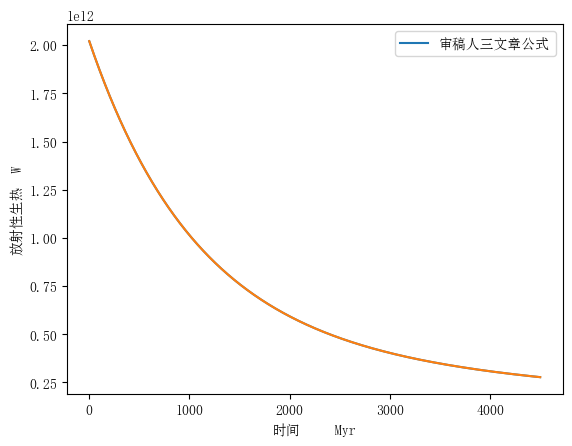

In [313]:
global C_Th_in
C_Th_in = CTh_in

Q_rad_manT_san = Q_radman( t_t )
Q_rad_manT_1 = Q_radman( t_t )



#plt.plot(t_t/s_yr/1e6 ,Q_rad_manT_san,label = "审稿人三，正确公式" )
#plt.plot(t_t/s_yr/1e6 ,Q_rad_manT_Tian ,label = "使用嫦娥五样品计算得到的热流值")
plt.plot(t_t/s_yr/1e6 ,Q_rad_manT_san,label = "审稿人三文章公式" )
plt.plot(t_t/s_yr/1e6 ,Q_rad_manT_1 )
#plt.plot(t_t/s_yr/1e6 ,Q_rad_manPeter ,label = "D2014 的公式" )

plt.xlabel("时间     Myr")
plt.ylabel("放射性生热  W")

plt.legend()

In [315]:
Em_K_1_0 = 4.0 #K'_0
Em_K_0 = 100e9
Em_alpha_0 = 4e-5
Em_delta_T = 4.5
Em_gamma_0 = 1.0
Em_gamma_1 = 1.4
Em_rho_0 = 3900 # 猜测的月幔顶部零压条件下的密度

In [317]:
Ec_K_1_0 = 5.5  #K'_0  ！！！5.5 为可能的取值
Ec_K_0 = 125e9   #  125 为可能的取值
Ec_alpha_0 = 5e-5 # 可能
Ec_delta_T = 4.5   # ！！可能
Ec_gamma_0 = 1.6   #！！可能
Ec_gamma_1 = 0.92   # ！！可能
Ec_rho_0 = 6000     # ！！6000 为火星的密度，影响因素为轻元素含量，后期需查阅文献修正

In [319]:
def foundfirst0(a):

    max = len(a)

    j = 0
    i = 0
    while i<max and j == 0:
        if a[i] == 0:
            j = 1
        i+=1
        
    return i-1

In [321]:
def Density_Structure(r,y,args): #用于 使用ode 求解器求解
    '''
    # r 为网格点 y为该点函数值的数组 args 为参数数组
    #根据设置不同的 args 计算幔与核的密度结构
    
    '''
    
    #赋值
    #print(t) #调试用
    
    rho_r , T_r , M_r , P_r = y # y 用于保存每一步的数据的数组  
    
    if M_r <= 0 :
        M_r = 1
    
    
    K_1_0 , K_0 , alpha_0 , delta_T , gamma_0 , gamma_1 , rho_0 , g_list = args
    
       

     
    x = rho_0/rho_r  #eq21 对于幔与核rho_0应该不同，因此需要设置不同的rho_0  
    
    theta = 3/2*(K_1_0-1) # eq 22
    alpha_x = alpha_0*x**delta_T # eq23 
    gamma_x = gamma_0*x**gamma_1 # eq24
    
        
    K_T = K_0 *(1+(1+theta*x**(1/3))*(1-x**(1/3)))*np.exp(theta*(1-x**(1/3)))*x**(-2/3)  #eq20   
    K_sr = K_T*(1+alpha_x*gamma_x*T_r) # eq19
    
    

    gamma_r = gamma_x #
    
    g_r = G*M_r/r**2 
    
    #print(g_r)
    
   

 #把每次计算出来的g_r追加到列表中
    #g.append(g_r)
    
    drho_dr = -rho_r**2*g_r/K_sr # eq 18 
    #drho_dr = 0.00004 #密度随半径的变化还有问题 
    dT_dr = -(rho_r*g_r*gamma_r)/K_sr*T_r #
    dM_dr = rho_r*4*math.pi*r**2 #eq 26 m = 4/3*pi*r**3
    dP_dr = -rho_r*g_r #eq 27 

    '''
    if M_r == 1 :
        print(f"R = {r}, Mass = 0")

    '''
        
    return [drho_dr , dT_dr , dM_dr , dP_dr]

In [323]:
def solve_P_x(x ,rho_shape_mantel):#！！！！！！！！注意！参数的选择均为地球情况！！！！！！！！！
    
    P = rho_shape_mantel[-1,3]
    
    K_1_0 = Em_K_1_0       # ！！！！！！月幔的 Bulk modulus gradient  不同行星参数有零点几的不同，后续需查阅文献更正！！！！！！
                      #  反应的是材料的抗压性质
    K_0 = Em_K_0      #  ！！！！！月幔的 Zero-pressure bulk modulus   暂定比火星低
    alpha_0 = Em_alpha_0    #！！！！！！月幔的参考热膨胀系数
    delta_T = Em_delta_T     #！！！月幔的热膨胀指数   4.5 也是可能的取值
    gamma_0 = Em_gamma_0     #！！！！！！Reference Grüneisen parameter  1.0是可能的取值 
    gamma_1 = Em_gamma_1     # ！！！！ Grüneisen parameter exponent  1.4 为可能的取值
    
    theta = 3/2*(K_1_0-1) # eq 22 
    alpha_x = alpha_0*x**delta_T # eq23 
    gamma_x = gamma_0*x**gamma_1 # eq24
 
    
    T_r = rho_shape_mantel[-2,1]
    K_T = K_0 *(1+(1+theta*x**(1/3))*(1-x**(1/3)))*np.exp(theta*(1-x**(1/3)))*x**(-2/3)  #eq20 
    K_s = K_T*(1+alpha_x*gamma_x*T_r)
    y = K_s - K_0 -P*K_1_0
    
    return y

In [324]:
def solve_M(rho , tem_mantel , tem_core ): 
    

    Em_g_list = []
    args_Em = (Em_K_1_0 , Em_K_0 , Em_alpha_0 , Em_delta_T ,Em_gamma_0 , Em_gamma_1 , Em_rho_0 , Em_g_list)

#设置网格
    r_mantel_end = R_c
    r_mantel_0 = R
    dr = -5
    nr = int((r_mantel_end - r_mantel_0 )/(dr))+1

    y_m_0 = [rho , tem_mantel , M_e , 1e5 ] #修改表面压力，修改表面密度,
                                       #文中的表面温度应该理解为上地幔的温度
    r_m = np.linspace(R , R_c , nr)
    
    r = integrate.ode(Density_Structure)
    r.set_integrator('dopri5')#使用四阶龙格库塔无法求解 但是vode 可以
    r.set_initial_value(y_m_0 , r_m[0])
    r.set_f_params(args_Em)
    dt = r_m[1] - r_m[0]
    rho_shape_mantel = np.zeros((len(r_m),len(y_m_0)))
    idx = 0
    while r.successful() and r.t>r_m[-1]:
        rho_shape_mantel[idx , :] = r.y
        r.integrate(r.t+dt) 
        idx += 1

        
     # 地球核的情况

    Ec_g_list = []
    args_Ec = (Ec_K_1_0 , Ec_K_0 , Ec_alpha_0 , Ec_delta_T ,Ec_gamma_0 , Ec_gamma_1 , Ec_rho_0 , Ec_g_list )
#设置网格
    r_core_0 = R_c
    r_core_end= 1
    dr = -5
    nr_core = int((r_core_end-r_core_0)/(dr))+1
        
    
    rho_shape_mantel[-1,:]=  rho_shape_mantel[-2,:]
     
    f = lambda x :solve_P_x(x ,rho_shape_mantel)
    rho_0_rho = optimize.newton(f,1) #rho_0/rho
    rho_c_UC = Ec_rho_0/rho_0_rho 
    
    #y_c_0 = [9570, 5700 ,rho_shape_mantel[-2,2] , rho_shape_mantel[-2,3] ] 
    y_c_0 = [rho_c_UC , tem_core ,rho_shape_mantel[-2,2] , rho_shape_mantel[-2,3] ] 

#密度，温度，质量，压力
#  压力就是核幔边界的压力
    r_c = np.linspace(r_core_0 , r_core_end , nr)
        
    
    
    r = integrate.ode(Density_Structure)
    r.set_integrator('dopri5')#使用四阶龙格库塔无法求解 但是vode 可以
    r.set_initial_value(y_c_0 , r_c[0])
    r.set_f_params(args_Ec)
    dt = r_c[1] - r_c[0]
    rho_shape_core = np.zeros((len(r_c),len(y_c_0)))
    idx = 0
    while r.successful() and r.t>r_c[-1]:
        rho_shape_core[idx , :] = r.y
        r.integrate(r.t+dt) 
        idx += 1
    
    rho_shape_core[-1,:] = rho_shape_core[-2,:]
    Ec_g_l =  G*rho_shape_core[:,2]/r_c**2
    alpha_mantel = Em_alpha_0*(Em_rho_0/rho_shape_mantel[:,0])**Em_delta_T
    alpha_core = Ec_alpha_0*(Ec_rho_0/rho_shape_core[:,0])**Ec_delta_T
    
    
    
    M = rho_shape_core[-1 , 2] 
    
        
    return M 

In [326]:
T_UP_mantel = 1300
T_cmb_0 =1900

In [328]:
'''
start =time.time()
f = lambda x :solve_M(x , T_UP_mantel,T_cmb_0) #假设月幔温度 1300 ，月核温度1900
rho_up_mantel = optimize.newton(f,3205) 
#rho = optimize.brenth(f,5000,5500) 
end = time.time()
print('Running time: %s Seconds'%(end-start))  
rho_up_mantel
'''

"\nstart =time.time()\nf = lambda x :solve_M(x , T_UP_mantel,T_cmb_0) #假设月幔温度 1300 ，月核温度1900\nrho_up_mantel = optimize.newton(f,3205) \n#rho = optimize.brenth(f,5000,5500) \nend = time.time()\nprint('Running time: %s Seconds'%(end-start))  \nrho_up_mantel\n"

In [329]:
rho_up_mantel = 3203.0491435368886

In [331]:
Em_g_list = []
args_Em = (Em_K_1_0 , Em_K_0 , Em_alpha_0 , Em_delta_T ,Em_gamma_0 , Em_gamma_1 , Em_rho_0 , Em_g_list)

#设置网格
r_mantel_end = R_c
r_mantel_0 = R
dr = -5
nr = int((r_mantel_end - r_mantel_0 )/(dr))+1

y_m_0 = [rho_up_mantel ,T_UP_mantel , M_e , 1e5 ] #修改表面压力，修改表面密度,
                                             #文中的表面温度应该理解为上地幔的温度
r_m = np.linspace(R , R_c , nr)
    
r = integrate.ode(Density_Structure)
r.set_integrator('dopri5') 
r.set_initial_value(y_m_0 , r_m[0])
r.set_f_params(args_Em)
dt = r_m[1] - r_m[0]
rho_shape_mantel = np.zeros((len(r_m),len(y_m_0)))
idx = 0
while r.successful() and r.t>r_m[-1]:
    rho_shape_mantel[idx , :] = r.y
    r.integrate(r.t+dt) 
    idx += 1
        
rho_shape_mantel[-1,:]=  rho_shape_mantel[-2,:]

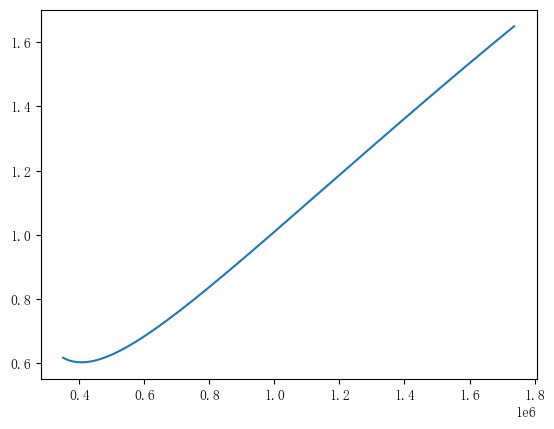

In [333]:
Em_g_list = G*rho_shape_mantel[:,2]/r_m**2
Em_g_list[-1]=Em_g_list[-2]
plt.plot(r_m,Em_g_list)

Text(0, 0.5, 'pa ')

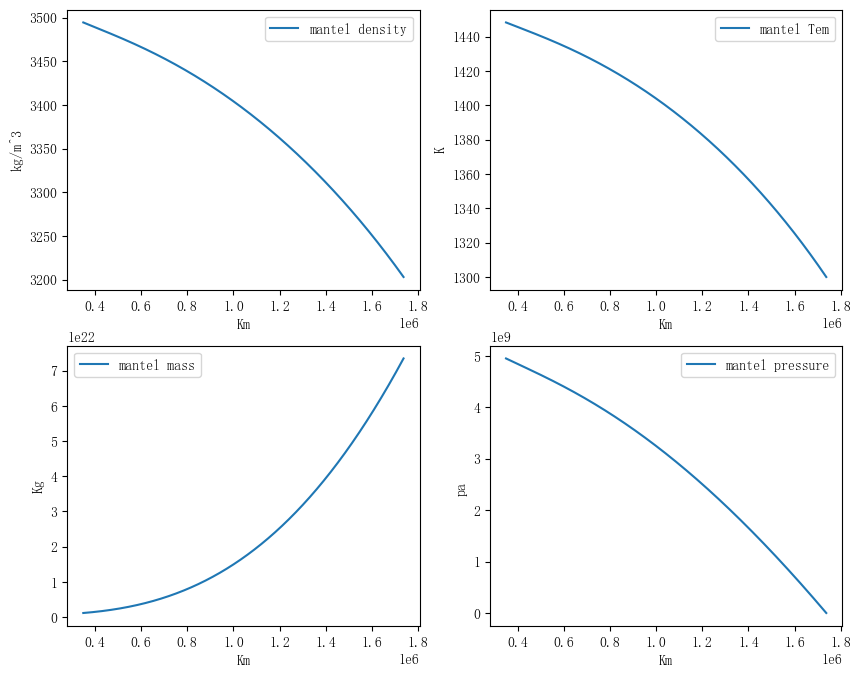

In [336]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(r_m[:-2],rho_shape_mantel[:-2,0],label='mantel density')
plt.legend()
plt.xlabel('Km')
plt.ylabel('kg/m^3')

plt.subplot(222)
plt.plot(r_m[:-2],rho_shape_mantel[:-2,1],label='mantel Tem')
plt.legend()
plt.xlabel('Km')
plt.ylabel('K')

plt.subplot(223)
plt.plot(r_m[:-2],rho_shape_mantel[:-2,2],label='mantel mass')
plt.legend()
plt.xlabel('Km')
plt.ylabel('Kg')

plt.subplot(224)
plt.plot(r_m[:-2],rho_shape_mantel[:-2,3],label='mantel pressure')
plt.legend()
plt.xlabel('Km')
plt.ylabel('pa ')

In [339]:
Ec_g_list = []
args_Ec = (Ec_K_1_0 , Ec_K_0 , Ec_alpha_0 , Ec_delta_T ,Ec_gamma_0 , Ec_gamma_1 , Ec_rho_0 , Ec_g_list )
#设置网格
r_core_0 = R_c
r_core_end= 1
dr = -5
nr_core = int((r_core_end-r_core_0)/(dr))+1
        
    
rho_shape_mantel[-1,:]=  rho_shape_mantel[-2,:]
     
f = lambda x :solve_P_x(x ,rho_shape_mantel)
rho_0_rho = optimize.newton(f,1) #rho_0/rho
rho_c_UC = Ec_rho_0/rho_0_rho 
    

y_c_0 = [rho_c_UC , T_cmb_0,rho_shape_mantel[-2,2] , rho_shape_mantel[-2,3] ] 
r_c = np.linspace(r_core_0 , r_core_end , nr)
        
    
    
r = integrate.ode(Density_Structure)
r.set_integrator('dopri5')#使用四阶龙格库塔求解 
r.set_initial_value(y_c_0 , r_c[0])
r.set_f_params(args_Ec)
dt = r_c[1] - r_c[0]
rho_shape_core = np.zeros((len(r_c),len(y_c_0)))
idx = 0


In [341]:
while r.successful() and r.t>r_c[-1]:
    rho_shape_core[idx , :] = r.y
    r.integrate(r.t+dt) 
    idx += 1
    
rho_shape_core[-1,:] = rho_shape_core[-2,:]
Ec_g_l =  G*rho_shape_core[:,2]/r_c**2
alpha_mantel = Em_alpha_0*(Em_rho_0/rho_shape_mantel[:,0])**Em_delta_T
alpha_core = Ec_alpha_0*(Ec_rho_0/rho_shape_core[:,0])**Ec_delta_T

Text(0, 0.5, 'pa ')

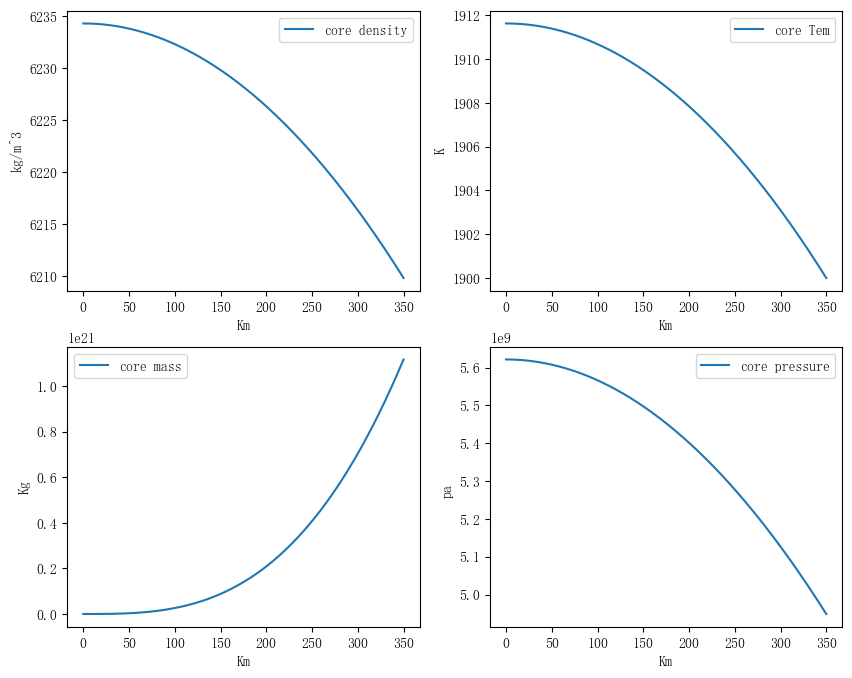

In [342]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(r_c[0:-2]/1000,rho_shape_core[:-2,0],label='core density')
plt.legend()
plt.xlabel('Km')
plt.ylabel('kg/m^3')

plt.subplot(222)
plt.plot(r_c[0:-2]/1000,rho_shape_core[:-2,1],label='core Tem')
plt.legend()
plt.xlabel('Km')
plt.ylabel('K')

plt.subplot(223)
plt.plot(r_c[0:-2]/1000,rho_shape_core[:-2,2],label='core mass')
plt.legend()
plt.xlabel('Km')
plt.ylabel('Kg')

plt.subplot(224)
plt.plot(r_c[0:-2]/1000,rho_shape_core[:-2,3],label='core pressure')
plt.legend()
plt.xlabel('Km')
plt.ylabel('pa ')

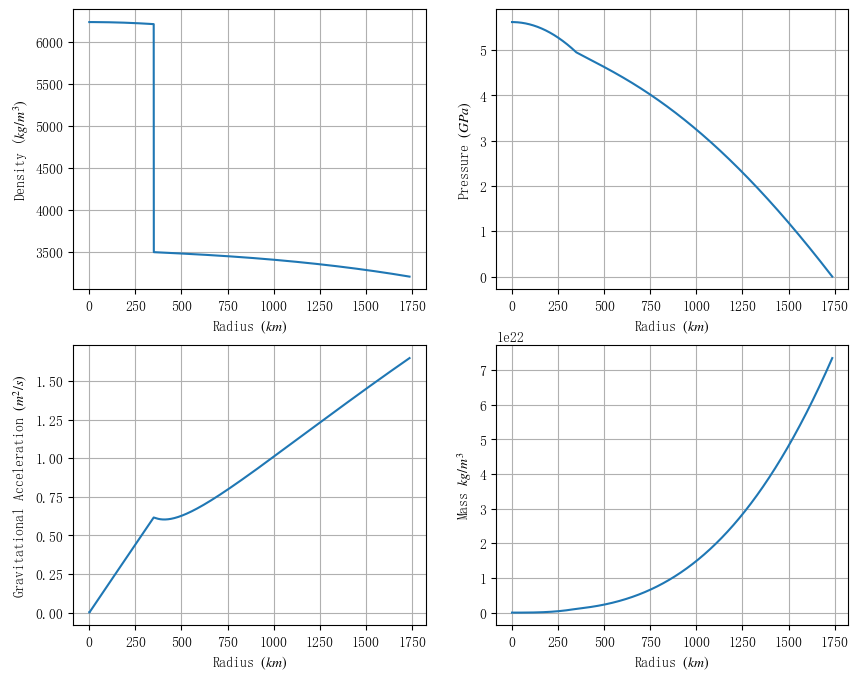

In [344]:
rho_shape_plan  = np.append(rho_shape_mantel , rho_shape_core,axis = 0)
rE = np.append(r_m,r_c)
Eg = np.append(Em_g_list,Ec_g_l)
Eg[-1] = Eg[-2]
E_alpha = np.append(alpha_mantel , alpha_core)


plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(rE/1e3,rho_shape_plan[:,0])
plt.xlabel('Radius $(km)$')
plt.ylabel('Density ($kg/m^3)$')

plt.grid()

plt.subplot(222)
plt.plot(rE/1e3,rho_shape_plan[:,3]/1e9)
plt.xlabel('Radius $(km)$')
plt.ylabel('Pressure $(GPa)$ ')
plt.grid()


plt.subplot(223)

plt.plot(rE/1e3,Eg)
plt.xlabel('Radius $(km)$')
plt.ylabel('Gravitational Acceleration $(m^2/s)$')
plt.grid()

plt.subplot(224)

plt.plot(rE/1e3,rho_shape_plan[:,2])
plt.xlabel('Radius $(km)$')
plt.ylabel('Mass $kg/m^3$')
plt.grid()

Text(0, 0.5, '/K')

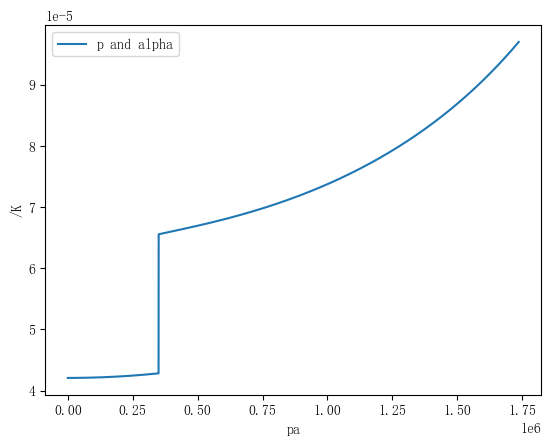

In [345]:
plt.plot(rE,E_alpha,label='p and alpha')
plt.legend()
plt.xlabel('pa')
plt.ylabel('/K')

In [346]:
#!!!!!不要删除
mass_mantel = rho_shape_mantel[0,2] - rho_shape_mantel[-2,2] 
mass_mantel 

7.235998905492916e+22

In [347]:
 rho_shape_plan[:,0]

array([3203.04914354, 3203.05099445, 3203.05284535, ..., 6234.32920913,
       6234.32920925, 6234.32920925])

In [348]:
rE

array([1.73700000e+06, 1.73699500e+06, 1.73699000e+06, ...,
       3.52342466e+00, 2.26171233e+00, 1.00000000e+00])

In [349]:
#！！！！！ 计算月球的转动惯量
jifen = rho_shape_plan[:,0]*(rE)**4
I0 = 8/3*np.pi*trapz(jifen ,(rE))
-I0/(M_e*R**2)

0.39338188547048075

# 计算温度结构

In [351]:
T_cmb  =1727
T_mantel = 1226 #5e19

In [352]:
def D_m_and_D_N(rho_shape_core , rho_shape_mantel ,r_c,alpha_0_c): #!!!!!!!!! alpha c 要进一步改进
    #输入地球内部各点处参数，计算D_m与D_N 
    # rho_shape_core 为网格点上参数 
    
    rho_0_c =  Ec_rho_0   #！！！！！！！！！0压下火星核的密度
    #alpha_0 = 4e-5 #H21  table 1 改
    rho_c_mean =  sum(rho_shape_core[:,0])/len(rho_shape_core)
    rho_c = rho_shape_core[:,0]
    x_r =rho_0_c/rho_c
    
    M_c = rho_shape_mantel[-1,2]
    Ec_delta_T = 3.0
    
    alpha_x =  alpha_0_c*x_r**Ec_delta_T
    dM_dr = rho_c*4*math.pi*r_c**2  # eq 26
    
    dM = rho_shape_core[:,2]
    
    #var_simps = -np.trapz(alpha_x*dM_dr,r_c) # eq 33改 加负号是因为积分上下限颠倒了
    var_simps = -np.trapz(alpha_x,dM) # eq33 与上式等价 

    alpha_c = 1/M_c*var_simps #*0.1

    
    #alpha_c = 2.0e-5
    #alpha_c = alpha_0*x_r**(-3) #  D11 eq8 #或用常数代替原式 33   
                                       #  D11 eq8不能直接代入 可使用常数代替，但是
                                       #从严谨性的角度考虑后续还是应该用原文的式子
    
    #print(alpha_c)
    
    d_0 = 5e6   #5.243e6
    d_1 = 1.689e7
    d_2 = -2.183e8
    d_3 = 2.752e9
    
    #D_N = np.sqrt((3*c_c)/(2*math.pi*alpha_c*rho_c_mean*G)) 
    #D_N = np.sqrt((3*c_c)/(2*math.pi*alpha_c*rho_0_c*G))  #这个参数只由热膨胀系数、密度决定，不同行星计算方法差别不大
      
    D_N = np.sqrt((3*c_c)/(2*math.pi*alpha_c*rho_c[-1]*G)) #!nimmo 2014
    #D_m = d_0 + d_1*X_s+d_2*X_s**2+d_3*X_s**3  # 这个参数对于不同行星该怎么选取？
    #D_m = 5000 #地球情况
    
    D_m =4400e3
    
    
    return D_m , D_N ,alpha_c

In [353]:
def core_temperature_structure(r , D_m , D_N ,T_cmb): 
    '''
    计算 半径r 处的温度以及熔点
    
    '''
    P = rho_shape_core[:,3]/1e9

    #X_s = 0.075 #摩尔质量分数
    #X_s = 0.6
    T_m0 = 1809
    T_m1 = 1.99e-11
    T_m2 = -1.87e-22
    T_remelt  = T_m0*(1+T_m1*rho_shape_core[:,3]+T_m2*rho_shape_core[:,3]**2) #hauck 2006

    T = T_cmb*np.exp((R_c**2 - r**2)/(D_N**2)) #与下面的方法最大只差了2K，故计算出的D_N是合理的  写文章的时候可以做一个比较图出来
    
    rho_c_mean =  sum(rho_shape_core[:,0])/len(rho_shape_core)
    #T = T_cmb*np.exp((men_alpha_c*(rho_shape_core[:,3]-rho_shape_core[0,3])/(rho_c_mean*c_c))) #hauck 2006
    #T = 0.2302*P**4-5.3688*P**3+38.124*P**2-46.681*P+1813.8
   
    
    T_m0S =1495
    T_m1S = 1.97e-11
    T_m2S = -1.43e-22
    
   # P = 0 
    #T_melt_0 = (-2.4724*P**4+28.025*P**3+9.1404*P**2+581.71*P+3394)*X_s**4+(1.7978*P**4-6.7881*P**3-197.69*P**2-271.69*P-8219.5)*X_s**3+(-0.1702*P**4-9.3959*P**3+163.53*P**2-319.35*P+5698.6)*X_s**2+(-0.2308*P**4+7.1*P**3-64.118*P**2+105.98*P-1621.9)*X_s+(0.2302*P**4-5.3688*P**3+38.124*P**2-46.681*P+1813.8)
    X_s_m = 0.3 #硫元素的摩尔分数 
    P = rho_shape_core[:,3]/1e9
    T_melt_1 = (-2.4724*P**4+28.025*P**3+9.1404*P**2+581.71*P+3394)*X_s_m**4+(1.7978*P**4-6.7881*P**3-197.69*P**2-271.69*P-8219.5)*X_s_m**3+(-0.1702*P**4-9.3959*P**3+163.53*P**2-319.35*P+5698.6)*X_s_m**2+(-0.2308*P**4+7.1*P**3-64.118*P**2+105.98*P-1621.9)*X_s_m+(0.2302*P**4-5.3688*P**3+38.124*P**2-46.681*P+1813.8)
#T_melt = T_m0S*(1+T_m1S*rho_shape_core[:,3]+T_m2S*rho_shape_core[:,3]**2)*(1-men_alpha_c*X_s) #hauck 2006 eq3 这个与上式拟合的较好！！
#T_melt_cen =T_melt[-1]
    
    T_melt_cen = T_melt_1[-1]
    gamma_G = 1.5 #Grüneisen parameter for the moon core
    #T_melt= T_melt_cen*np.exp(-2*(1-1/(3*gamma_G))*r**2/-3150e3**2) 
   #根据上式修改
    T_melt = T_melt_cen*np.exp(-r**2/4400e3**2)
    
    
    the_r = (np.log(T_melt_cen/T_cmb)- (R_c/D_N)**2)/(D_m**(-2)-D_N**(-2))
   # the_r = (np.log(T_cmb/T_melt_cen)+R_c**2/D_N**2)/(1/D_N**2+1/D_m**2)
   
        
        
    
    if the_r <= 0:
        R_int =0
        
    else :
        R_int = np.sqrt(the_r)
        
    if R_int>R_c:
        
        R_int = R_c

            
            
    M_c = rho_shape_mantel[-1,2]
    dM = rho_shape_core[:,2]
    T_c = -np.trapz(T,dM)/M_c #平均温度
            
    
    return T ,  T_melt ,T_remelt , T_c , R_int 

In [354]:
C_D_M , C_D_N ,men_alpha_c = D_m_and_D_N(rho_shape_core,rho_shape_mantel ,r_c,alpha_0_c)
r = r_c
D_N = C_D_N
D_m = C_D_M
#T_cmb = 2000

    #X_s = 0.075 #摩尔质量分数
    #X_s = 0.6
T_m0 = 1809
T_m1 = 1.99e-11
T_m2 = -1.87e-22
T_remelt  = T_m0*(1+T_m1*rho_shape_core[:,3]+T_m2*rho_shape_core[:,3]**2) #hauck 2006

T = T_cmb*np.exp((R_c**2 - r**2)/(D_N**2)) #与下面的方法最大只差了2K，故计算出的D_N是合理的  写文章的时候可以做一个比较图出来
    
rho_c_mean =  sum(rho_shape_core[:,0])/len(rho_shape_core)

   
    
T_m0S =1495
T_m1S = 1.97e-11
T_m2S = -1.43e-22
P = 0 
T_melt_0 = (-2.4724*P**4+28.025*P**3+9.1404*P**2+581.71*P+3394)*X_s**4+(1.7978*P**4-6.7881*P**3-197.69*P**2-271.69*P-8219.5)*X_s**3+(-0.1702*P**4-9.3959*P**3+163.53*P**2-319.35*P+5698.6)*X_s**2+(-0.2308*P**4+7.1*P**3-64.118*P**2+105.98*P-1621.9)*X_s+(0.2302*P**4-5.3688*P**3+38.124*P**2-46.681*P+1813.8)
P = rho_shape_core[:,3]/1e9
X_s = 0.3  # 摩尔浓度
T_melt_1 = (-2.4724*P**4+28.025*P**3+9.1404*P**2+581.71*P+3394)*X_s**4+(1.7978*P**4-6.7881*P**3-197.69*P**2-271.69*P-8219.5)*X_s**3+(-0.1702*P**4-9.3959*P**3+163.53*P**2-319.35*P+5698.6)*X_s**2+(-0.2308*P**4+7.1*P**3-64.118*P**2+105.98*P-1621.9)*X_s+(0.2302*P**4-5.3688*P**3+38.124*P**2-46.681*P+1813.8)
#T_melt = T_m0S*(1+T_m1S*rho_shape_core[:,3]+T_m2S*rho_shape_core[:,3]**2)*(1-men_alpha_c*X_s) #hauck 2006 eq3 这个与上式拟合的较好！！
#T_melt_cen =T_melt[-1]
    
T_melt_cen = T_melt_1[-1]
gamma = 1.5 #Grüneisen parameter for the moon core

#T_melt2 = T_s0*np.exp(-2*(1-1/(3*gamma))*r**2/10000e3**2) 
#T_melt2 = T_melt_cen*np.exp(-2*(1-1/(3*gamma))*r**2/-3150e3**2) 
T_melt2 = T_melt_cen*np.exp(-r**2/4400e3**2) 
#X_s = 0.065
#T_melt3 = T_m0S*(1+T_m1S*rho_shape_core[:,3]+T_m2S*rho_shape_core[:,3]**2)*(1-men_alpha_c*X_s)

#(np.log(T_melt_cen/T_cmb)- (R_c/D_N)**2)/(D_m**(-2)-D_N**(-2))
the_r = (np.log(T_melt_cen/T_cmb)- (R_c/D_N)**2)/(D_m**(-2)-D_N**(-2))









In [355]:
T_melt_1

array([1725.62658582, 1725.62669139, 1725.62679697, ..., 1737.42860438,
       1737.42860443, 1737.42860443])

In [356]:
T_melt_cen 

1737.4286044251166

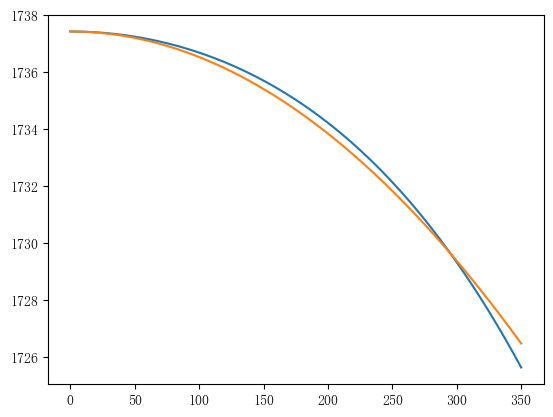

In [357]:
#拟合的月核固相线
plt.plot(r_c/1e3,T_melt_1)
plt.plot(r_c/1e3,T_melt2) 

In [358]:
C_D_M , C_D_N ,men_alpha_c = D_m_and_D_N(rho_shape_core,rho_shape_mantel ,r_c,alpha_0_c)
c_T , cT_melt ,T_remelt,T_c ,cR_int = core_temperature_structure(r_c , C_D_M, C_D_N ,T_cmb )
T_c

1730.9888873596894

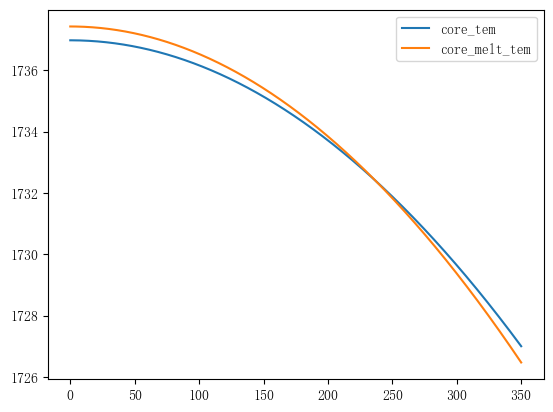

In [359]:
plt.plot(r_c/1e3,c_T , label = 'core_tem')
plt.plot(r_c/1e3,cT_melt ,label= 'core_melt_tem')
plt.legend()

In [360]:
# 计算月幔温度剖面

In [362]:
def mantel_tem_shape(r_m ,T_m ,T_cmb ): #T_m是一个值
    
    K_1_0 = Em_K_1_0 #！！！ 这一部分可修改
    K_0 = Em_K_0
    
    men_R_m = int(((R_c+R)/2-R_c)/5)#eq42 改
    
   
    
    
    
    alpha_m = alpha_mantel[men_R_m]
    g_m = Em_g_list[men_R_m] 
    g_cmb =  Em_g_list[-1]
    g_surf = Em_g_list[0]

    
    #T_m_shape = T_m*np.exp(alpha_m*g_m/c_m*(r_m[men_R_m]- r_m))
    T_m_shape = T_m*np.exp(alpha_m*g_m/c_m*((R+R_c)/2- r_m))

    
    delta_LM = 0
    delta_UM = 0
    T_LM =  abs(T_m_shape[-int(delta_LM/5)] )
    T_UM = abs(T_m_shape[int(delta_LM/5)])
    
    i = 0 
    a =10
    b =10
    while i<27740: #a > 2 and b >2:
        
        P_LM = rho_shape_mantel[-int(delta_LM/5),3]
        P_UM = rho_shape_mantel[int(delta_UM/5),3]
        rho_LM = rho_shape_mantel[-int(delta_LM/5),0]
        rho_UM = rho_shape_mantel[int(delta_UM/5),0]
    
    
        k_LM = k_0*(1+P_LM*K_1_0/K_0) 
        k_UM = k_0*(1+P_UM*K_1_0/K_0) 
        #k_UM  = 4.2
        #k_LM =  5
    
        kappa_LM = k_LM/(rho_LM*c_m) 
        kappa_UM = k_UM/(rho_UM*c_m)
        
        Delta_T_LM = abs(T_cmb - T_m_shape[-int(delta_LM/5)])
        Delta_T_UM  = abs(T_m_shape[int(delta_UM/5)] - T_surf)

    

        
        '''
        #这个式子是 H21 文中的式子，算出来非常不对 故使用下文D14
        mu_UM = mu_vef*np.exp(A_v/R_g*(1/T_UM-1/T_ref))
        mu_LM = 15*mu_UM
        '''
        act_visc = A_v
        #mu_UM = v_0*np.exp(A_v/R_g*(1/T_UM-1/T_ref))/rho_shape_mantel[int(delta_UM/5),0] #运动粘度
        #mu_LM = v_0*np.exp(A_v/R_g*(1/T_LM-1/T_ref))/rho_shape_mantel[-int(delta_LM/5),0]

        mu_UM = v_0*np.exp(A_v/R_g*(1/T_UM-1/T_ref))/rho_shape_mantel[int(delta_UM/5),0] #运动粘度
        mu_LM = v_0*np.exp(A_v/R_g*(1/T_LM-1/T_ref))/rho_shape_mantel[-int(delta_LM/5),0]
        #mu_UM = mu_vef*np.exp(act_visc/(R_g*T_UM))
        #mu_LM = visc_ref_LM*np.exp(act_visc/(R_g*T_LM))
        
        #mu_LM = vis_ratio*mu_UM #要使达到文中图像一样的斜率需使用该式 使用上式计算出的 LM与UM的粘度差小于10
        
        delta_LM =abs(( (Ra_crit*kappa_LM*mu_LM)/(alpha_m*g_cmb*Delta_T_LM))**(1/3))
        delta_UM =abs(( (Ra_crit*kappa_UM*mu_UM)/(alpha_m*g_surf*Delta_T_UM))**(1/3))
        
                
        if delta_LM > R-R_c or delta_UM > R-R_c or delta_LM + delta_UM == R-R_c:
            delta_LM = R-R_c
            delta_UM = R-R_c
            

            
            
    
    
        a = abs(T_m_shape[-int(delta_LM/5)] -T_LM )
        b = abs(T_m_shape[int(delta_UM/5)] - T_UM )
        T_LM = T_m_shape[-int(delta_LM/5)]  
        T_UM = T_m_shape[int(delta_LM/5)]
        
        i+=1


        if i > 277400:
            print("i大于277400")
            
            break
            

    

    T_m_shape[-int(delta_LM/5)-1:] = np.linspace( T_m_shape[-int(delta_LM/5)], T_cmb  ,int(delta_LM/5)+1)
    T_m_shape[:int(delta_UM/5)] = np.linspace( 300 , T_m_shape[int(delta_UM/5)] ,int(delta_UM/5))
    
    
    Delta_T_LM  = T_cmb - T_m_shape[-int(delta_LM/5)]
    Delta_T_UM  = T_m_shape[int(delta_UM/5)] - T_surf
    T_LM =  abs(T_m_shape[-int(delta_LM/5)] )
    T_UM = abs(T_m_shape[int(delta_UM/5)])
    
    return T_m_shape , delta_UM ,delta_LM ,Delta_T_UM , Delta_T_LM ,T_UM , T_LM ,k_UM,k_LM,mu_UM, mu_LM

In [363]:
r_m.shape

(277401,)

In [364]:
k_m = k_0*(1+rho_shape_mantel[:,3]*Em_K_1_0/Em_K_0) 
k_c = k_0*(1+rho_shape_core[:,3]*Ec_K_1_0/Ec_K_0) 
k_p = np.append(k_m,k_c)

In [365]:
plt.rcParams['font.sans-serif'] = ['SimHei']
#设置中文字体
plt.rcParams['axes.unicode_minus'] = False
#设置负号显示

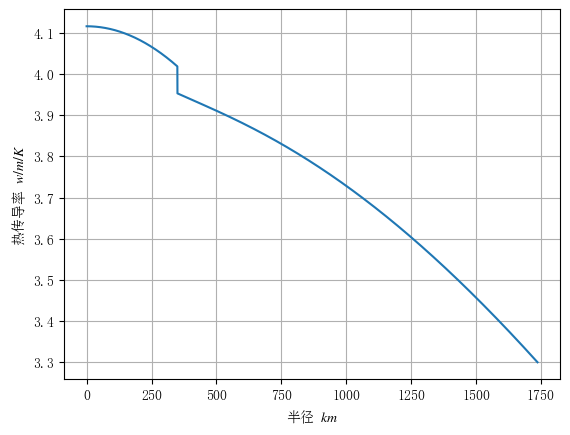

In [366]:
plt.plot(rE/1000,k_p)
plt.xlabel("半径 $km$")
plt.ylabel("热传导率 $w/m/K$")
plt.grid()
plt.savefig('热传导系数.png',format='png',dpi=600)

In [367]:
    x = rho_shape_mantel[-1,0]/rho_up_mantel
    P = rho_shape_mantel[-1,3]
    
    K_1_0 = Em_K_1_0       # ！！！！！！月幔的 Bulk modulus gradient  不同行星参数有零点几的不同，后续需查阅文献更正！！！！！！
                      #  反应的是材料的抗压性质
    K_0 = Em_K_0      #  ！！！！！月幔的 Zero-pressure bulk modulus   暂定比火星低
    alpha_0 = Em_alpha_0    #！！！！！！月幔的参考热膨胀系数
    delta_T = Em_delta_T     #！！！月幔的热膨胀指数   4.5 也是可能的取值
    gamma_0 = Em_gamma_0     #！！！！！！Reference Grüneisen parameter  1.0是可能的取值 
    gamma_1 = Em_gamma_1     # ！！！！ Grüneisen parameter exponent  1.4 为可能的取值
    
    theta = 3/2*(K_1_0-1) # eq 22 
    alpha_x = alpha_0*x**delta_T # eq23 
    gamma_x = gamma_0*x**gamma_1 # eq24
 
    
    T_r = rho_shape_mantel[-2,1]
    K_T = K_0 *(1+(1+theta*x**(1/3))*(1-x**(1/3)))*np.exp(theta*(1-x**(1/3)))*x**(-2/3)  #eq20 
    K_s = K_T*(1+alpha_x*gamma_x*T_r)

In [369]:
liutilinglixuexingzhi= pd.concat([
                  pd.DataFrame({"core_radius":r_c}),
                  pd.DataFrame({"Buono2011":T_melt_1}),
                  pd.DataFrame({"Dm = 4.4e6":T_melt2}),
                  pd.DataFrame({"RE":rE}),
                  pd.DataFrame({"Density":rho_shape_plan[:,0]}),
                  pd.DataFrame({"Pressure":rho_shape_plan[:,3]}),
                  pd.DataFrame({"Mass":rho_shape_plan[:,2]}),
                  pd.DataFrame({"Conductivity":k_p}),
                  pd.DataFrame({"'Gravitational Acceleration":Eg}),
                 ],axis=1)
                 
liutilinglixuexingzhi.to_csv("liutilinglixuexingzhi.csv")

# 加入Melt

In [371]:
def DeltaT_melt(T_UM):
        
    gamma_z = 3.9e-6 #K/m Mantle solidus gradient (H00)
    gamma_ad = 1e-6 #K/m Magma adiabatic gradient (M88)
    
    T_g = T_s
        
    z2 = (T_UM - T_sol0)/gamma_z 
    z_melt = z2/2
    
    T_melt = (T_UM+T_sol0)/2
    T = T_melt - T_s - z_melt*gamma_ad
    
    return T

In [372]:
def T_sol_P(P):  #2000 - Hirschmann 
    
    a = -5.1
    b = 132.9
    c = 1085
    T = a*(P/1e9)**2+b*(P/1e9)+c+273.15
    
    return T

In [373]:
43*(100/10000)**0.75

1.359779393872403

In [374]:
def p2018f(Tm ,T_UM ,delta_UM):
    
     
    
    #f = (T_UM - T_sol(R-delta_UM))/(500) #eq 32
    I =int(delta_UM/5)
    #print(I)
    #P = rho_shape_mantel[I,3]
    #T_sol11 = T_sol_P(P)
    T_sol11 = T_sol_P(rho_shape_mantel[I,3])
    f = (T_UM - T_sol11)/(T_liq_P(rho_shape_mantel[I,3])-T_sol_P(rho_shape_mantel[I,3]) )
    #T_sol11 = T_sol_P_shengaorensan(rho_shape_mantel[I,3])
   # f = (T_UM - T_sol11)/(T_liq_Pshengaorensan(rho_shape_mantel[I,3])-T_sol_P_shengaorensan (rho_shape_mantel[I,3]) )
    
    
    
    if f>1:
        f = 1

    elif f<0:
        f = 0
    
    
    return f

In [375]:
def mass_flux1(T_m ,T_UM , delta_UM ): #
    
   
    #v_UM = mu_UM
    
    kappa = Em_kappa
    rho_solid = Em_rho_solid
    
    #print(f"delta_UM : {delta_UM}") #用于检查
    
    #Ap = Np*Lp*Lr
    
    Ap = A    #直接用星球表面积拟合

    dot_Vup = 1.16*kappa*Ap/delta_UM
    
    mass_flux1 = epsilon_e*dot_Vup*rho_solid*p2018f(T_m ,T_UM ,delta_UM) 

    
    
    return mass_flux1

In [376]:
def Qmelt(Tm,T_UM,delta_UM):
    
    
    Q = mass_flux1(Tm ,T_UM , delta_UM)*(L_melt+c_m*DeltaT_melt(T_UM))
    
    return Q , mass_flux1(Tm ,T_UM , delta_UM)

In [377]:
def T_liq_P(P):  #Richard F. Katz and Marc Spiegelman 200
    
    a = -3.2
    b = 80
    c = 1475
    T = a*(P/1e9)**2+b*(P/1e9)+c+273.15
    
    return T

In [378]:
273.15+ 1475

1748.15

In [379]:
def T_liq_D15(P):  #Richard F. Katz and Marc Spiegelman 200
    

    T = 2035+57.46*P-3.4872*P**2+0.0769*P**3
    
    return T

In [380]:
def T_sol_P(P):  #2000 - Hirschmann 
    
    a = -5.1
    b = 132.9
    c = 1085
    T = a*(P/1e9)**2+b*(P/1e9)+c+273.15
    
    return T

In [381]:
def T_sol_P_shengaorensan(P):  
    
    d = 0.1054
    a = -6.581
    b = 134.2
    c = 1409
    T = d*(P/1e9)**3 +a*(P/1e9)**2+b*(P/1e9)+c
    
    return T

In [382]:
def T_liq_Pshengaorensan(P):  
    
    d = 0.0769
    a = -3.4872
    b = 57.46
    c = 2035
    T = d*(P/1e9)**3 +a*(P/1e9)**2+b*(P/1e9)+c
    
    return T

In [383]:
def Foundmelt(r_m ,Tm , T_c_mb , T_sol_shape):
    i = 0

    Tm_shape , delta_UM ,delta_LM ,Delta_T_UM , Delta_T_LM ,T_UM , T_LM ,k_UM,k_LM,mu_UM, mu_LM = mantel_tem_shape(r_m ,Tm ,T_cmb )
    zhizhen = Tm_shape - T_sol_shape
    for T in zhizhen:
        if T> 0:
            i = 1
            break


    return i

In [385]:
X_H20 = 280e-4
Delta_T_X_H2O = 318*X_H20**0.75
Delta_T_X_H2O 

21.766852958801792

Text(0.5, 0, '半径 （km）')

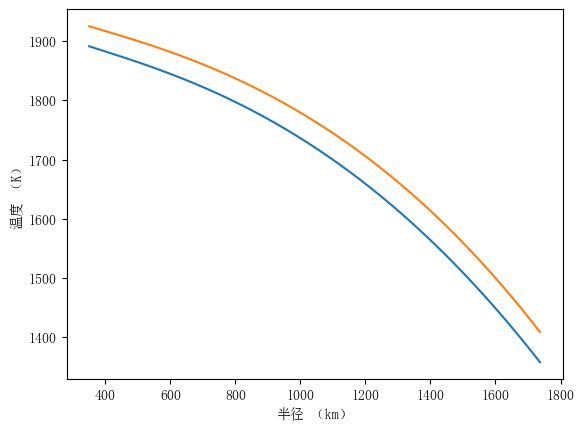

In [386]:
our_sol = T_sol_P(rho_shape_mantel[:,3])
shengaorensan_sol = T_sol_P_shengaorensan(rho_shape_mantel[:,3])

plt.plot(r_m/1e3 ,our_sol )
plt.plot(r_m/1e3 ,shengaorensan_sol )
plt.ylabel("温度 （K）")
plt.xlabel("半径 （km）")

In [447]:
start = time.time()
T_m_shape5e19 , delta_UM ,delta_LM ,Delta_T_UM , Delta_T_LM ,T_UM , T_LM ,k_UM,k_LM,mu_UM, mu_LM= mantel_tem_shape(r_m ,1600,2000)#5e19
#T_m_shape2e19 , delta_UM ,delta_LM ,Delta_T_UM , Delta_T_LM ,T_UM , T_LM ,k_UM,k_LM,mu_UM, mu_LM= mantel_tem_shape(r_m ,1196,1726 )#2e19
end = time.time()
print('Running time: %s Seconds'%(end-start)) 



Running time: 0.1918935775756836 Seconds


In [391]:
D_m , D_n , men_alpha_c= D_m_and_D_N(rho_shape_core , rho_shape_mantel ,r_c,alpha_0_c) 
T , T_melt ,T_remelt, T_c , R_int = core_temperature_structure(r_c ,D_m ,D_n ,1727)

plt.plot(r_m/1000,T_m_shape5e19,label = "月幔温度")
#plt.plot(r_m/1000, T_sol_P(rho_shape_mantel[:,3]),ls = "-.",label = "月幔固相线")
plt.xlabel("半径 km")
plt.ylabel("月幔温度 K")
plt.legend()
plt.savefig("初始月幔温度.png",dpi = 600)

In [393]:
T_shape2 = np.append(T_m_shape5e19,T)
#T_shape = np.append(T_m_shape5e19,T)
#plt.plot(r_c/1000,T)

In [394]:
delta_UM

321992.82452321134

In [397]:
plt.rcParams['font.sans-serif'] = ['SimHei']
#设置中文字体
# 统一设置
plt.rcParams['axes.unicode_minus'] = False
#设置负号显示
font1 = {'family': 'Times New Roman',
'weight' : 'normal',
'size' : 8,
}

from matplotlib import rcParams

config = {
    "font.family":'serif',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

Text(0, 0.5, '温度 K')

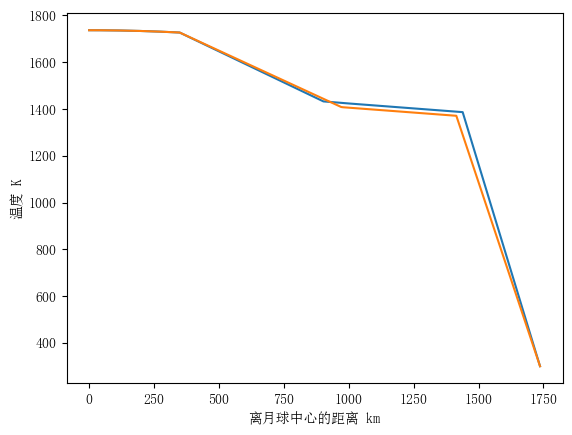

In [398]:
plt.plot(rE/1000,T_shape,label = "Temperature")
plt.plot(rE/1000,T_shape2,label = "Temperature")

#plt.plot(r_m/1000 , T_liq_P(rho_shape_mantel[:,3]))
#plt.plot(r_m , shengaorensan_sol-300)
#plt.plot(r_m/1000 , T_sol_P(rho_shape_mantel[:,3]),ls = "-.",label = "月幔固相线")
#plt.plot(r_c/1000 ,T_melt2 )
#plt.axvspan(xmin=rE[int(delta_UM/5)]/1000, xmax=rE[1]/1000, color="gray", alpha=0.3)
#plt.axvspan(xmin=r_m[int(-delta_LM/5)]/1000, xmax=r_c[1]/1000, color="gray", alpha=0.3)
#plt.axvspan(xmin=r_c[-1]/1000, xmax=r_c[1]/1000, color="red", alpha=0.3,label = "月核")
#plt.axvspan(xmin=r_m[int(-delta_LM/5)]/1000, xmax=rE[int(delta_UM/5)]/1000, color="yellow", alpha=0.3,label = "月幔对流区")
#plt.plot(r_m ,shengaorensan_sol )
plt.xlabel("离月球中心的距离 km")
plt.ylabel("温度 K")
#plt.legend(loc = 3)
#plt.savefig('初始温度结构.png',format='png',dpi=600)

Text(0, 0.5, '粘度 $Pa·s$')

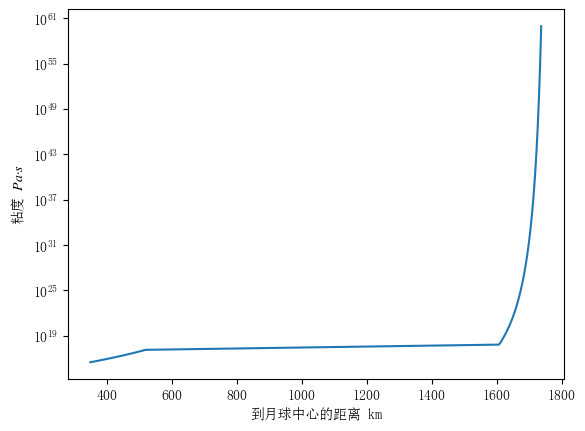

In [463]:
plt.plot(r_m/1000,eta_r,label = "Temperature")
plt.yscale("log")
plt.xlabel("到月球中心的距离 km")
plt.ylabel("粘度 $Pa·s$")

In [451]:
eta_r = v_0*np.exp(A_v/R_g*(1/T_m_shape5e19-1/T_ref))/rho_shape_mantel[:,0]

In [110]:
rE[int(delta_UM/5)]/1000

1439.445

In [111]:
r_m[int(-delta_LM/5)]/1000

903.595

In [112]:
T_liq_mantel = T_liq_P(rho_shape_mantel[:,3])

#T_sol_my =  T_sol_P(rho_shape_mantel[:,3])
#plt.plot(r_m , T_sol_my)   


# 磁场

In [189]:
def Dipole_Moment(R_ic,q_cmb, T_cmb, dotR_ic , men_alpha_core ,R_remelt ,dotR_snow ,D_N ,rho_c_mean,alpha_0_c):#使用DN_DM算出的值
    
    gamma = 0.2  #the saturation constant for fast rotating  dipolar dynamos  
    
    d = R_c - R_ic 
    
    if d ==0:
        d =1
   
    '''
    if R_ic == 0:
        
        R_ic = 1
        
    '''
    
    #alpha_c = men_alpha_core 
    

    rho_c = rho_shape_core[:,0]
    rho_0_c =  6900
    x_r = rho_0_c/rho_c
    alpha_x =  alpha_0_c*x_r**Ec_delta_T
    
    M_c = rho_shape_mantel[-1,2]
    
    dM = rho_shape_core[:,2]
    

    var_simps = -np.trapz(alpha_x,dM) # H21 eq33 与上式等价 

    alpha_c = 1/M_c*var_simps #*0.1

    
    
    #alpha_c = 1.45e-5 
    
    g_cmb = Em_g_list[-1]
    
    sigema_c = 1e6
    L_c = 2.5e-8
    k_c = sigema_c*L_c*T_cmb 
    
    #F_T
    #q_ad = -k_c*(-alpha_c*g_cmb/c_c)*T_cmb #H21
    q_ad = k_c*T_cmb*R_c/C_D_N**2 # D14 eq38
    q_T = q_cmb - q_ad
    F_T = alpha_c*g_cmb/(rho_c_mean *c_c) *q_T
    
    #F_X
    
    Delta_rho_x = 400  #地球 这个可以试试改改
    g_icb = g_cmb*(R_ic/R_c)
    F_X = g_icb*Delta_rho_x/rho_c_mean*(R_ic/R_c)**2*dotR_ic
    
    if F_X < 0 :
        F_X = 0
    
    #F_S
    
    rho_snow = 1/((1-X_s_sol)/rho_Fe+(X_s_sol/rho_s))
    Delta_rho_snow =  rho_snow - rho_c_mean#!!!!!火星
    
    g_remelt = g_cmb*R_remelt/R_c
    F_S = g_remelt+Delta_rho_snow/rho_c_mean*(R_remelt/R_c)**2*(-dotR_snow)
    
    F_c = F_T + F_X+F_S 
    
    '''
    if F_c >0:
         m = 4*math.pi*R_c**3*gamma*(rho_c_mean/mu_0)**(1/2)*(F_c*d)**(1/3)
            
    else :
        
        m = 0
    '''
    if F_c < 0 :
        F_c = 0
        
    m = 4*math.pi*R_c**3*gamma*(((rho_c_mean/mu_0)**(1/2)))*(F_c*d)**(1/3)
    
    
    
    return m ,F_c ,F_X,F_T,F_S

# 热收支

In [191]:
mass_core = rho_shape_mantel[-1,2]
mass_man = M_e - mass_core

In [192]:
def Heat_history(t, y, arg):
    
    T_m = y[0]
    T_cmb = y[1]

    
    #传入行星结构
    mantel_shape =  rho_shape_mantel
    core_shape = rho_shape_core
    
    D_m , D_n , men_alpha_c= D_m_and_D_N(rho_shape_core , rho_shape_mantel ,r_c,alpha_0_c) 
      
    T , T_melt ,T_remelt, T_c , R_int = core_temperature_structure(r_c ,D_m ,D_n ,T_cmb)


    
    #print(f"Tm = {T_m} , Tc = {T_c}")
    T_m_shape , delta_UM ,delta_LM ,Delta_T_UM , Delta_T_LM ,T_UM , T_LM ,k_UM,k_LM ,visc_UM, visc_LM= mantel_tem_shape(r_m ,T_m , T_cmb )

    
    #Q_rad_man =  Q_rad_man_initial*np.exp(-t/tau_rad) #!!!!!!!!
    #Q_rad_man = (U238_in*np.exp(np.log(2)*-t/s_yr/4.46e9)+U235_in*np.exp(np.log(2)*-t/s_yr/7.04e8) 
        #+Th232_in*np.exp(np.log(2)*-t/s_yr/1.4e10)+K40_in*np.exp(np.log(2)*-t/s_yr/1.26e9) )*mass_mantel
    Q_rad_man = Q_radman(t)
    #Q_rad_man =0
    Q_rad_core = Q_rad_core_intial*np.exp(-t/tau_rad_core)
    #Q_rad_core =0
    
    #visc_LM =   5*visc_UM  
    Q_conv = area_e*k_UM*(Delta_T_UM)/delta_UM   
    
    #k_LM = 40
    Q_cmb = area_cmb*k_LM*(Delta_T_LM)/delta_LM  
    #Q_cmb = area_cmb*4*(Delta_T_LM)/delta_LM  
    
    Pe = 0.1
    #Q_melt = Pe*Q_conv #这里可以用更好的模型代替
    Q_melt ,mass_flux = Qmelt(T_m,T_UM,delta_UM)
    
    dTdt_m = (Q_rad_man+Q_cmb-Q_conv-Q_melt)/(mass_man*c_m) #查一下cp两篇文章取值是否相同
    #dTdt_m =(Q_rad_man+Q_cmb-Q_conv)/(mass_man*c_m) 
    L_Fe  = 7.5e5 #J/Kg
    E_G = 3e5*R_c/3.48e6 #J/kg
    
    rho_int = core_shape[-int(R_int/5) ,0] 
    #print(R_int)
    
    dTdt_c = (Q_rad_core-Q_cmb)/(mass_core*c_c+((2*math.pi*R_int*rho_int*(L_Fe+E_G))/((D_m**(-2)-D_n**(-2))*T_c)))
    #dTdt_c = (Q_rad_core-Q_cmb)/(mass_core*c_c+((2*math.pi*R_int*rho_int*(L_Fe))/((D_m**(2)-D_n**(2))*T_c)))
    
    #dTdt_c = (Q_rad_core-Q_cmb)/(mass_core*c_c)
    dTdt_cmb = T_cmb*dTdt_c/T_c
    
    
    R_ic = R_int
    R_snow = 0
    R_remelt = 0
    

    
            

    #q_cmb = k_LM*Delta_T_LM/delta_LM 
    q_cmb = Q_cmb/area_cmb

    #if R_ic > 0:
       # dotR_ic = -1/(2*R_ic)*(1/(D_m**(-2)-D_n**(-2)))*dTdt_cmb /T_cmb
    #else:
        #dotR_ic = 0
        

    if R_ic == 0:
        R_ic = 1
        
    dotR_ic = -1/(2*R_ic)*(1/(D_m**(-2)-D_n**(-2)))*dTdt_cmb /T_cmb
    
    
    
    
    dotR_snow = 0 #1/(2*R_snow)*(np.log(T_cmb/T_melt[-1])/(1/D_n**2+1/D_m**2)/T_cmb)*dTdt_cmb 
    rho_c_mean = core_shape[-int(1/2*(R_c/5)),0] 
    
    M, F_c ,F_X,F_T,F_S= Dipole_Moment(R_ic,q_cmb,T_cmb, dotR_ic , men_alpha_c ,R_remelt ,dotR_snow ,D_n,rho_c_mean,alpha_0_c)
    
    #print(M)
    #M= 0
    Lconv_t = R-R_c-(delta_UM+delta_LM)
    
    arg[0] = Q_rad_man
    arg[1] = Q_rad_core
    arg[2] = Q_conv
    arg[3] = Q_cmb
    arg[4] = Q_melt
    arg[5] = visc_UM
    arg[6] = visc_LM
    arg[7] = delta_UM
    arg[8] = delta_LM   
    arg[9] = M
    arg[10] = R_int
    
    arg[11] = F_c
    #arg[11] = T_UM
    arg[12] = F_X
    arg[13] = F_T
    arg[14] = F_S
    
    arg[15] = mass_flux
    arg[16] = Lconv_t
    
    return [dTdt_m , dTdt_cmb]

In [250]:
global A_v 
A_v = 3e5
global  Q_rad_man_initial
#Q_rad_man_initial = 1.21864077e+12#
Q_rad_man_initial = 0
global epsilon_e
epsilon_e = 0.02 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|

global C_Th_in 
#C_Th_in = 120e-9  
#C_Th_in    = 1.3640557832603814e-07
C_Th_in = 90e-09
#C_Th_in = 33.9e-9

In [251]:
T_m_initial = 1600
T_cmb_initial = 2000
T_time_0 = [T_m_initial , T_cmb_initial] 

s_yr = 3600.*24*365
t_end = 4.5e9*s_yr
dt = 1e6*s_yr
t_0 = 0
nt = int((t_end-t_0)/dt)+1
t_t  = np.linspace(t_0 , t_end , nt)

In [254]:
#dianliname = f"T_m_{T_m_initial}_Tcmb_{T_cmb_initial}v_0{v_0}.csv"

In [255]:
params_names = ['Q_rad_man','Q_rad_core','Q_conv','Q_cmb','Q_melt','visc_UM','visc_LM','delta_UM','delta_LM','M','F_C','F_X','F_T','F_S','mass_flux',"Lconv_t"]
j_Q_rad_man = 0
j_Q_rad_core = 1
j_Q_conv = 2
j_Q_cmb = 3
j_Q_melt = 4
j_visc_UM = 5
j_visc_LM = 6
j_delta_UM = 7
j_delta_LM = 8
j_M = 9
j_R_ic = 10
j_F_c = 11
j_F_X = 12
j_F_T = 13
j_F_S = 14
j_mass_flux = 15
j_Lconv = 16
params = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ,0,0]

In [256]:
visc_UM_t = np.zeros(nt)
visc_LM_t = np.zeros(nt)
delta_UM_t = np.zeros(nt)
delta_LM_t = np.zeros(nt)
Q_conv_t = np.zeros(nt)
Q_cmb_t = np.zeros(nt)
Q_rad_man_t = np.zeros(nt)
Q_rad_core_t = np.zeros(nt)
Q_melt_t = np.zeros(nt)
M_t = np.zeros(nt)
R_ic_t = np.zeros(nt)
F_c_t = np.zeros(nt)
F_X_t = np.zeros(nt)
F_T_t = np.zeros(nt)
F_S_t = np.zeros(nt)
mass_flux_t = np.zeros(nt)
Lconv_t = np.zeros(nt)

In [260]:
r = integrate.ode(Heat_history)
#r.set_integrator('dopri5')
#r.set_integrator('vode')
r.set_initial_value(T_time_0, t_t[0])
r.set_f_params(params)

plan_them_history = np.zeros((len(t_t),len(T_time_0)))
idx = 0

start =time.time()
while r.successful() and r.t < t_end:

    plan_them_history[idx , :] = r.y
    r.integrate(r.t+dt) 
    params = r.f_params[0]
    visc_UM_t[idx] = params[j_visc_UM]
    visc_LM_t[idx] = params[j_visc_LM]
    delta_UM_t[idx] = params[j_delta_UM]
    delta_LM_t[idx] = params[j_delta_LM]
    Q_conv_t[idx] = params[j_Q_conv]
    Q_cmb_t[idx] = params[j_Q_cmb]
    Q_rad_man_t[idx] = params[j_Q_rad_man]
    Q_rad_core_t[idx] = params[j_Q_rad_core] 
    Q_melt_t[idx] = params[j_Q_melt]
    M_t[idx] =  params[j_M]
    R_ic_t[idx] = params[j_R_ic]
    F_c_t[idx] = params[j_F_c]
    F_X_t[idx] = params[j_F_X]
    F_T_t[idx] = params[j_F_T]
    F_S_t[idx] = params[j_F_S]
    mass_flux_t[idx] = params[j_mass_flux]
    Lconv_t[idx] = params[j_Lconv]
    
    idx += 1
    
    end = time.time()
    print(f"{idx}/{nt}")

print('Running time: %s Seconds'%(end-start)) 

    
gyr = t_t/s_yr*1e-9
j=0
print('t=%.2e yr T_m=%.2f T_cmb=%.2f'%(t_t[j]/s_yr,plan_them_history[j,0],plan_them_history[j,1]))
j=-2
print('t=%.2e yr T_m=%.2f T_cmb=%.2f'%(t_t[j]/s_yr,plan_them_history[j,0],plan_them_history[j,1]))

1/4501
2/4501
3/4501
4/4501
5/4501
6/4501
7/4501
8/4501
9/4501
10/4501
11/4501
12/4501
13/4501
14/4501
15/4501
16/4501
17/4501
18/4501
19/4501
20/4501
21/4501
22/4501
23/4501
24/4501
25/4501
26/4501
27/4501
28/4501
29/4501
30/4501
31/4501
32/4501
33/4501
34/4501
35/4501
36/4501
37/4501
38/4501
39/4501
40/4501
41/4501
42/4501
43/4501
44/4501
45/4501
46/4501
47/4501
48/4501
49/4501
50/4501
51/4501
52/4501
53/4501
54/4501
55/4501
56/4501
57/4501
58/4501
59/4501
60/4501
61/4501
62/4501
63/4501
64/4501
65/4501
66/4501
67/4501
68/4501
69/4501
70/4501
71/4501
72/4501
73/4501
74/4501
75/4501
76/4501
77/4501
78/4501
79/4501
80/4501
81/4501
82/4501
83/4501
84/4501
85/4501
86/4501
87/4501
88/4501
89/4501
90/4501
91/4501
92/4501
93/4501
94/4501
95/4501
96/4501
97/4501
98/4501
99/4501
100/4501
101/4501
102/4501
103/4501
104/4501
105/4501
106/4501
107/4501
108/4501
109/4501
110/4501
111/4501
112/4501
113/4501
114/4501
115/4501
116/4501
117/4501
118/4501
119/4501
120/4501
121/4501
122/4501
123/4501
1

In [222]:
#mass_flux_105 = mass_flux_t[:-2]

In [223]:
foundfirst0(mass_flux_t)

1997

In [225]:
Q_conv_t

array([1.24103321e+12, 1.24103321e+12, 1.24103321e+12, ...,
       4.06931050e+11, 4.06931050e+11, 0.00000000e+00])

Text(0, 0.5, '喷发熔体质量通量  kg/s')

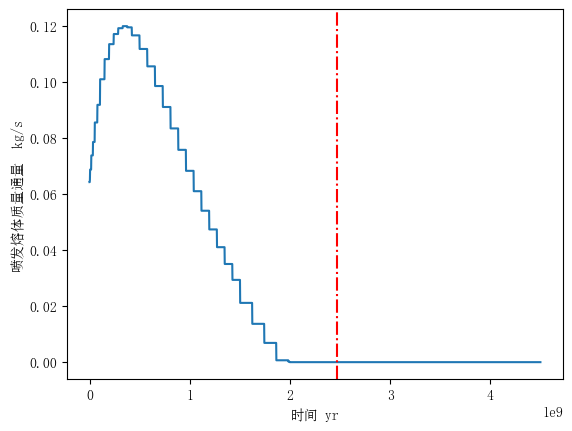

In [226]:
plt.plot(t_t[:-2]/s_yr,mass_flux_t[:-2]/rho_up_mantel*s_yr/1e9)
plt.axvline(x=2470e6,ls='-.',label = "Chang'e-5 basalts",color = "red")
plt.xlabel("时间 yr")
plt.ylabel("喷发熔体质量通量  kg/s")

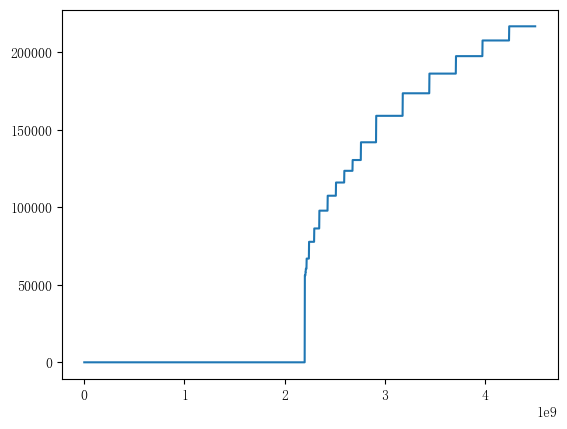

In [221]:
plt.plot(t_t[:-1]/s_yr,R_ic_t[:-1])

In [222]:
mass_flux_t[:-2]/rho_up_mantel*s_yr/1e9

array([0.06466081, 0.06466081, 0.06582859, ..., 0.        , 0.        ,
       0.        ])

In [223]:
yudata = pd.read_csv('yudata.csv')
yudata = np.array(yudata)

cankaosuanli = pd.read_csv('Qusual.csv')
cankaosuanli = np.array(cankaosuanli)

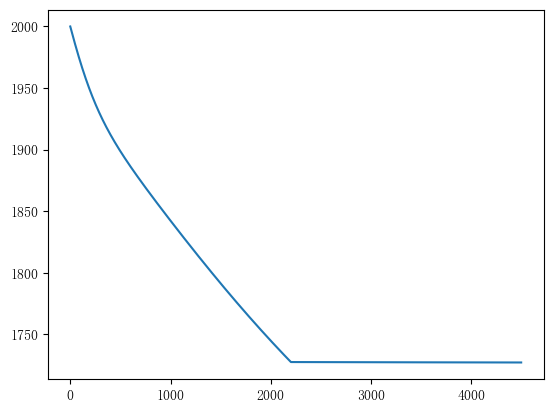

In [224]:
plt.plot((t_t[:-2]/s_yr )/1e6,plan_them_history[:-2,1])

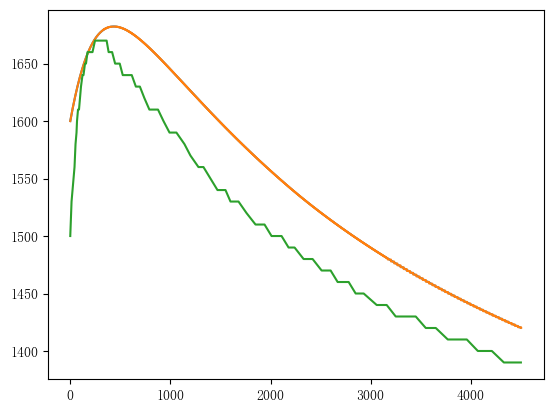

In [225]:
plt.plot((t_t[:-2]/s_yr )/1e6,plan_them_history[:-2,0])
plt.plot( cankaosuanli[:-2,7]/s_yr/1e6 , cankaosuanli[:-2,1])
plt.plot(yudata[:,0],yudata[:,1])
#plt.plot(t_t[:-2]/s_yr-4.5e9,plan_them_history[:-2,1])

# plt.plot(t_t[:-1]/s_yr,R_ic_t[:-1])

In [227]:
Q_conv_t[-2]/(4*np.pi*R**2) *1000

12.759940936441298

# 平滑曲线

In [229]:
i = 0
Q_conv = np.zeros(nt)
Q_nu = np.zeros(nt)
Q_rad_man =np.zeros(nt)
Q_cmb=np.zeros(nt)
Q_melt=np.zeros(nt)
mass_flux_t=np.zeros(nt)
delta_UM_t =   np.zeros(nt)
delta_LM_t = np.zeros(nt)
T_UM_t = np.zeros(nt)
T_LM_t = np.zeros(nt)
k_UM_t=np.zeros(nt)
k_LM_t =np.zeros(nt)
visc_UM_t=np.zeros(nt)
visc_LM_t =np.zeros(nt)
L_conv_t_t = np.zeros(nt)
Ra_m_t =  np.zeros(nt)
Ur_t = np.zeros(nt)
#Q_tidal_t = np.zeros(nt)

D_m , D_n , men_alpha_c= D_m_and_D_N(rho_shape_core , rho_shape_mantel ,r_c,alpha_0_c)

R_int_H = np.zeros(nt)

while i < nt:
    
    T_m =  plan_them_history[i,0]
    T_cmb =  plan_them_history[i,1]
   # print(f"T_m = {T_m},T_cmb = {T_cmb}")
    
    #传入行星结构
    mantel_shape =  rho_shape_mantel
    core_shape = rho_shape_core
    
    D_m , D_n , men_alpha_c= D_m_and_D_N(rho_shape_core , rho_shape_mantel ,r_c,alpha_0_c) 
      
    T , T_melt ,T_remelt, T_c , R_int = core_temperature_structure(r_c ,D_m ,D_n ,T_cmb)
    
    
    #print(f"Tm = {T_m} , Tc = {T_c}")
    T_m_shape , delta_UM_t[i] ,delta_LM_t[i] ,Delta_T_UM , Delta_T_LM ,T_UM_t[i] , T_LM_t[i] ,k_UM_t[i],k_LM_t[i] ,visc_UM, visc_LM= mantel_tem_shape(r_m ,T_m , T_cmb )
    visc_UM = visc_UM
    
    visc_LM =   2*visc_UM  
    Q_conv[i] = area_e*k_UM*(Delta_T_UM)/delta_UM_t[i]  
    t= t_t[i]
    
    Q_rad_man[i] =  Q_rad_man_initial*np.exp(-t/tau_rad) #!!!!!!!!
    
    
    #k_LM = 40
    Q_cmb[i] = area_cmb*k_LM*(Delta_T_LM)/delta_LM_t[i]  
    
    
    Pe = 0.1
    #Q_melt = Pe*Q_conv #这里可以用更好的模型代替
    Q_melt[i],mass_flux_t[i] = Qmelt(T_m,T_UM_t[i],delta_UM_t[i])
    
    Q_nu[i] = k_LM*4*math.pi*R**2*(T_cmb-T_s)/(R-R_c)
    

    
    L_Fe  = 7.5e5
    E_G = 3e5
    

    
    rho_int = core_shape[-int(R_int/5) ,0] 
    #print(R_int)
    
    
    
    #dTdt_c = (Q_rad_core-Q_cmb)/(mass_core*c_c)
    
    
    
    R_ic = R_int    

    q_cmb = Q_cmb/area_cmb
    rho_M_A = 3350 #kg/m^3
    kappa_UM = k_UM_t[i]/(rho_M_A*c_m)
    alpha_m_A = 4e-5
    g_surf = 1.5 #m^2/s
    Ra_m_t[i] =  (alpha_m_A*g_surf*(T_cmb - T_surf)*(R-R_c)**3)/(kappa_UM*visc_UM)

    Ur_t[i] = Q_rad_man_t[i]/ Q_conv[i]
    
    #if R_ic > 0:
       # dotR_ic = -1/(2*R_ic)*(1/(D_m**(-2)-D_n**(-2)))*dTdt_cmb /T_cmb
    #else:
        #dotR_ic = 0
        

    if R_ic == 0:
        R_ic = 1
        
    
    T_H , T_melt_H,T_remelt_H, T_c_H , R_int_H[i] = core_temperature_structure(r_c ,D_m ,D_n ,plan_them_history[i,1])
    if R_int_H[i] > 350000:
        R_int_H[i]  = 350000
    
    i+= 1
    print(f"{i}/{nt}")



1/4501
2/4501
3/4501
4/4501
5/4501
6/4501
7/4501
8/4501
9/4501
10/4501
11/4501
12/4501
13/4501
14/4501
15/4501
16/4501
17/4501
18/4501
19/4501
20/4501
21/4501
22/4501
23/4501
24/4501
25/4501
26/4501
27/4501
28/4501
29/4501
30/4501
31/4501
32/4501
33/4501
34/4501
35/4501
36/4501
37/4501
38/4501
39/4501
40/4501
41/4501
42/4501
43/4501
44/4501
45/4501
46/4501
47/4501
48/4501
49/4501
50/4501
51/4501
52/4501
53/4501
54/4501
55/4501
56/4501
57/4501
58/4501
59/4501
60/4501
61/4501
62/4501
63/4501
64/4501
65/4501
66/4501
67/4501
68/4501
69/4501
70/4501
71/4501
72/4501
73/4501
74/4501
75/4501
76/4501
77/4501
78/4501
79/4501
80/4501
81/4501
82/4501
83/4501
84/4501
85/4501
86/4501
87/4501
88/4501
89/4501
90/4501
91/4501
92/4501
93/4501
94/4501
95/4501
96/4501
97/4501
98/4501
99/4501
100/4501
101/4501
102/4501
103/4501
104/4501
105/4501
106/4501
107/4501
108/4501
109/4501
110/4501
111/4501
112/4501
113/4501
114/4501
115/4501
116/4501
117/4501
118/4501
119/4501
120/4501
121/4501
122/4501
123/4501
1

C:\Users\10623\AppData\Local\Temp\ipykernel_17172\3623667892.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  the_r = (np.log(T_melt_cen/T_cmb)- (R_c/D_N)**2)/(D_m**(-2)-D_N**(-2))
C:\Users\10623\AppData\Local\Temp\ipykernel_17172\2356432879.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  mu_UM = v_0*np.exp(A_v/R_g*(1/T_UM-1/T_ref))/rho_shape_mantel[int(delta_UM/5),0] #运动粘度
C:\Users\10623\AppData\Local\Temp\ipykernel_17172\2356432879.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  mu_LM = v_0*np.exp(A_v/R_g*(1/T_LM-1/T_ref))/rho_shape_mantel[-int(delta_LM/5),0]


4501/4501


In [230]:
for r in R_int_H:
    print(r)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [231]:
Q_rad_man = Q_radman(t_t)

In [232]:
t_t.shape

(4501,)

In [233]:
R_int_H

array([     0.        ,      0.        ,      0.        , ...,
       216309.69175331, 216342.53228287, 350000.        ])

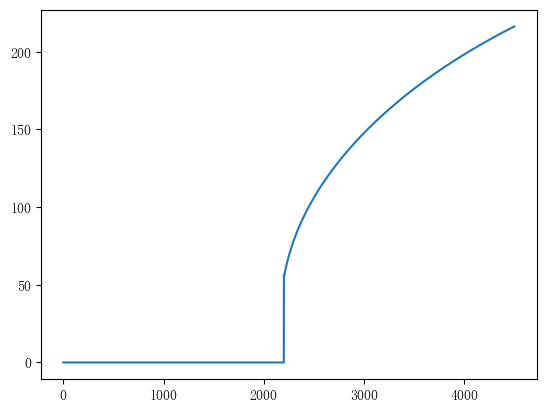

In [234]:
plt.plot(t_t[:-2]/s_yr/1e6  ,R_int_H[:-2]/1000)

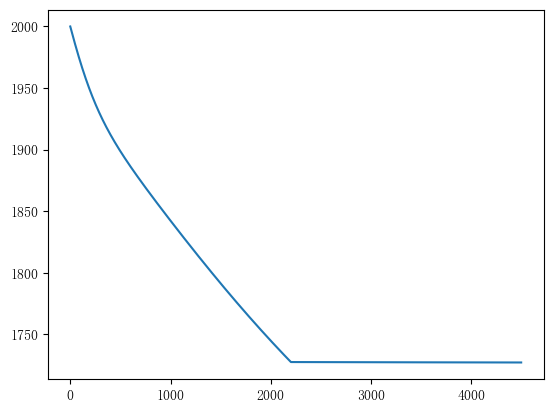

In [262]:
plt.plot(t_t[:-2]/s_yr/1e6  ,plan_them_history[:-2,1] )

In [236]:
Q_tidal_t = np.zeros(nt)

In [237]:
T_shape

array([ 300.        ,  300.04807487,  300.09614974, ..., 2011.55505358,
       2011.55505358, 2011.55505358])

In [238]:
Tsol = T_sol_P(rho_shape_mantel[:,3])

In [307]:
s = pd.concat([ pd.DataFrame({'0tidaltem':plan_them_history[:-2,0]}),
                pd.DataFrame({'1Q_conv':Q_conv}),
                pd.DataFrame({'2Q_rad_man':Q_rad_man}),
                pd.DataFrame({'3Q_cmb':Q_cmb}),
                pd.DataFrame({'4Q_melt':Q_melt}),
                pd.DataFrame({'5mass_flux_t':mass_flux_t}),
                pd.DataFrame({'6time':t_t}),
                pd.DataFrame({'7Ric':R_int_H }),
                pd.DataFrame({'8Tfin':T_shape }),
                pd.DataFrame({'9RM':rE }),
                pd.DataFrame({'Tsol ':Tsol  }),
                pd.DataFrame({'Tcore ':plan_them_history[:-2,1]  }),



] ,axis=1)

s.to_csv('Qusual.csv' )

In [425]:
#Tem_33 = plan_them_history[:-2,0]
#mass_flux_t_33 = mass_flux_t
#Q_rad_t_33 = Q_radman(t_t)
#Ur_33 = Q_rad_t[:-1]/Q_conv[:-1] 
#Q_conv_33 = Q_conv
#Q_conv = Q_rad_t_33[:-1]/Ur_33
#Ur_33_xiuzheng = Q_rad_t_77[:-1]/Q_conv

NameError: name 'Q_rad_t_77' is not defined

In [214]:
Q_conv[-2]/(4*np.pi*R**2) *1000

12.914886341116132

In [216]:
Q_rad_t = Q_radman(t_t)
Ur = Q_rad_t/Q_conv

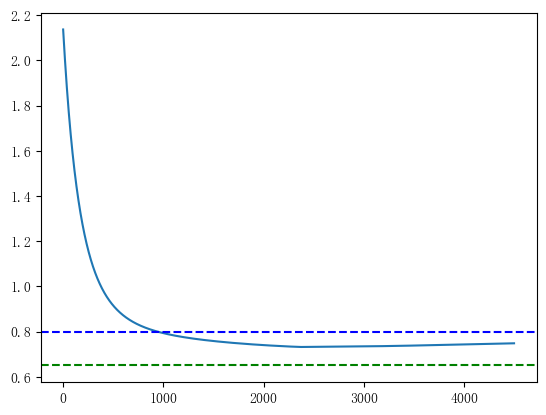

In [218]:
plt.plot(t_t[:-2]/s_yr/1e6 , Ur[:-2])
plt.axhline(y=0.8, ls='--', c='blue')
plt.axhline(y=0.65, ls='--', c='green')

In [ ]:
plt.plot()

Text(0, 0.5, '喷发熔体质量通量  $km^3/yr$')

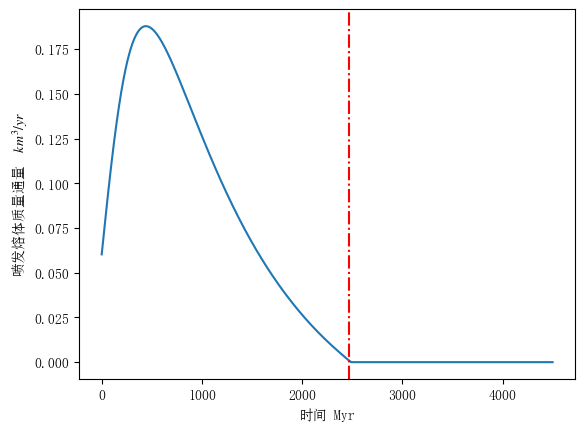

In [221]:
plt.plot(t_t[:-2]/s_yr/1e6,mass_flux_t[:-2]/rho_up_mantel*s_yr/1e9)
plt.axvline(x=2470e6/1e6,ls='-.',label = "Chang'e-5 basalts",color = "red")
plt.xlabel("时间 Myr")
plt.ylabel("喷发熔体质量通量  $km^3/yr$")

In [462]:
rho_up_mantel

3203.0491435368886

In [727]:
global C_Th_in 
#C_Th_in = 120e-9  
#C_Th_in    = 1.3640557832603814e-07
#C_Th_in = 1.0205314067553884e-07
#C_Th_in = 7.722940375446183e-08
C_Th_in = 33.7e-9

Q_rad_t_33 = Q_radman(t_t)

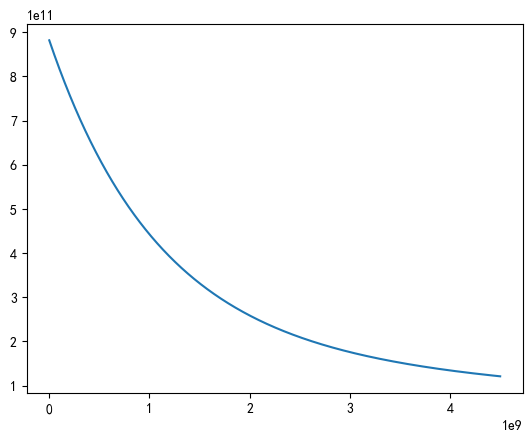

In [731]:
plt.plot(t_t/s_yr,Q_rad_t_33 )

In [555]:
Tem_99 = plan_them_history[:-2,0]
mass_flux_t_99 = mass_flux_t
Q_rad_t_99 = Q_radman(t_t)
Q_conv_99 = Q_conv
Ur_99 = Q_rad_t_99[:-1]/Q_conv[:-1] 

In [539]:
Q_conv[:-1]

array([4.17516553e+12, 4.16741949e+12, 4.15972210e+12, ...,
       4.97797281e+11, 4.97691446e+11, 4.97585454e+11])

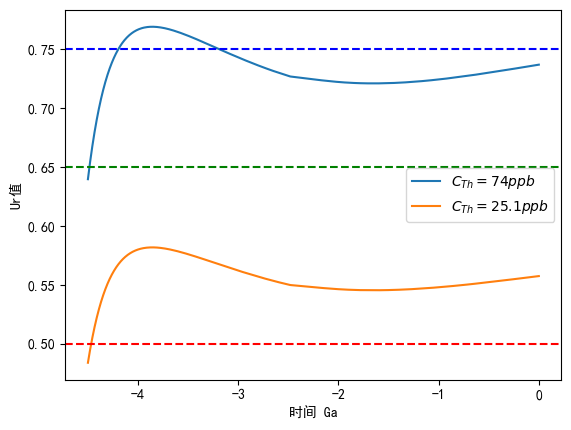

In [725]:
plt.plot((t_t[:-1]/s_yr-4.5e9)/1e9, Ur_99,label = "$C_{Th} =74 ppb$")
plt.plot((t_t[:-1]/s_yr-4.5e9)/1e9, Ur_33_xiuzheng,label = "$C_{Th} = 25.1 ppb$")

plt.axhline(y=0.75, ls='--', c='blue')
plt.axhline(y=0.65, ls='--', c='green')
plt.axhline(y=0.5, ls='--', c='red')

plt.xlabel("时间 Ga")
plt.ylabel("Ur值")
plt.legend()

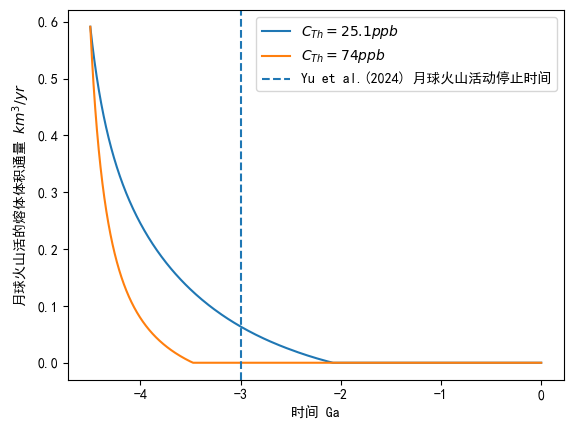

In [617]:
plt.plot((t_t[:]/s_yr-4.5e9)/1e9,mass_flux_t*s_yr/rho_up_mantel/1e9,label = "$C_{Th} = 25.1 ppb$")
plt.plot((t_t[:]/s_yr-4.5e9)/1e9,mass_flux_t_33*s_yr/rho_up_mantel/1e9,label = "$C_{Th} =74 ppb$")
plt.axvline(x=-3e9/1e9, ls='--', label='Yu et al.(2024) 月球火山活动停止时间')

plt.ylabel("月球火山活的熔体体积通量 $km^3/yr$")
plt.xlabel("时间 Ga")
plt.legend()

In [719]:
shengaosan_data  = np.loadtxt('z.csv', delimiter=',')
tem = shengaosan_data[:-1,1]
sanci_data = interpolate.interp1d( Time,  tem , kind = 3)

ValueError: Expect x to not have duplicates

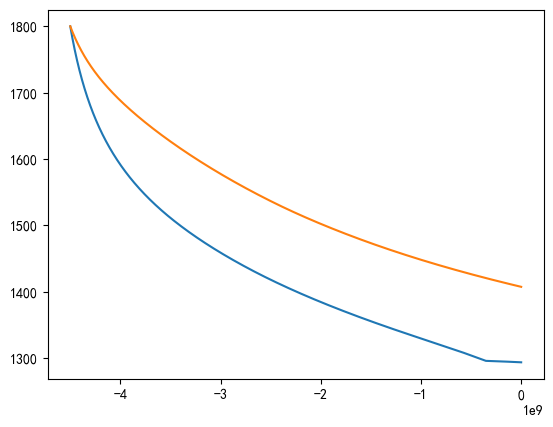

In [581]:
plt.plot((t_t[:]/s_yr-4.5e9)/1e9,Tem_33,label = "$C_{Th} = 25.1 ppb$")
plt.plot((t_t[:]/s_yr-4.5e9)/1e9,Tem_99,label = "$C_{Th} = 25.1 ppb$")

plt.ylabel("月幔平均温度 K ")
plt.xlabel("时间 Ga")
plt.legend()

In [575]:
Tem_99

array([1800.        , 1799.59953465, 1799.20053401, ..., 1407.23443591,
       1407.19851158, 1407.16259564])

# 测试粘度的影响

In [1]:
def the_v_0_t(v_0_t ):
    global v_0
    v_0 = v_0_t  
    T_m_initial = 1600
    T_cmb_initial =  2000
    T_time_0 = [T_m_initial , T_cmb_initial] 

    s_yr = 3600.*24*365
    t_end = 4.5e9*s_yr
    dt = 1e6*s_yr
    t_0 = 0
    nt = int((t_end-t_0)/dt)+1
    t_t  = np.linspace(t_0 , t_end , nt)
    params_names = ['Q_rad_man','Q_rad_core','Q_conv','Q_cmb','Q_melt','visc_UM','visc_LM','delta_UM','delta_LM','M','F_C','F_X','F_T','F_S','mass_flux',"L_conv"]
    j_Q_rad_man = 0
    j_Q_rad_core = 1
    j_Q_conv = 2
    j_Q_cmb = 3
    j_Q_melt = 4
    j_visc_UM = 5
    j_visc_LM = 6
    j_delta_UM = 7
    j_delta_LM = 8
    j_M = 9
    j_R_ic = 10
    j_F_c = 11
    j_F_X = 12
    j_F_T = 13
    j_F_S = 14
    j_mass_flux = 15
    j_Lconv = 16
    params = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ,0,0]
    visc_UM_t = np.zeros(nt)
    visc_LM_t = np.zeros(nt)
    delta_UM_t = np.zeros(nt)
    delta_LM_t = np.zeros(nt)
    Q_conv_t = np.zeros(nt)
    Q_cmb_t = np.zeros(nt)
    Q_rad_man_t = np.zeros(nt)
    Q_rad_core_t = np.zeros(nt)
    Q_melt_t = np.zeros(nt)
    M_t = np.zeros(nt)
    R_ic_t = np.zeros(nt)
    F_c_t = np.zeros(nt)
    F_X_t = np.zeros(nt)
    F_T_t = np.zeros(nt)
    F_S_t = np.zeros(nt)
    mass_flux_t = np.zeros(nt)
    Lconv_t =  np.zeros(nt)
    
    r = integrate.ode(Heat_history)
    r.set_integrator('dopri5 ')
    r.set_initial_value(T_time_0, t_t[0])
    r.set_f_params(params)

    plan_them_history = np.zeros((len(t_t),len(T_time_0)))
    idx = 0
    
    while r.successful() and r.t < t_end:
        start =time.time()
        plan_them_history[idx , :] = r.y
        r.integrate(r.t+dt) 
        params = r.f_params[0]
        visc_UM_t[idx] = params[j_visc_UM]
        visc_LM_t[idx] = params[j_visc_LM]
        delta_UM_t[idx] = params[j_delta_UM]
        delta_LM_t[idx] = params[j_delta_LM]
        Q_conv_t[idx] = params[j_Q_conv]
        Q_cmb_t[idx] = params[j_Q_cmb]
        Q_rad_man_t[idx] = params[j_Q_rad_man]
        Q_rad_core_t[idx] = params[j_Q_rad_core] 
        Q_melt_t[idx] = params[j_Q_melt]
        M_t[idx] =  params[j_M]
        R_ic_t[idx] = params[j_R_ic]
            
        F_c_t[idx] = params[j_F_c]
        F_X_t[idx] = params[j_F_X]
        F_T_t[idx] = params[j_F_T]
        F_S_t[idx] = params[j_F_S]
        mass_flux_t[idx] = params[j_mass_flux]
        Lconv_t[idx] = params[j_Lconv]
    
        idx += 1
    
    fin_T_m = plan_them_history[-2,0]
    fin_T_c = plan_them_history[-2,1]
    fin_M_flux = mass_flux_t[-2]
    fin_Tm_flux =  Q_conv_t[-2]+Q_melt_t[-2]
    M_flux_tGa = mass_flux_t[-2000]
    
    vendtime = foundfirst0(mass_flux_t)
            
    return  vendtime , fin_Tm_flux/(4*np.pi*R**2) 

In [511]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

In [513]:
s_yr = 3600.*24*365
t_end = 4.5e9*s_yr
dt = 1e6*s_yr
t_0 = 0
nt = int((t_end-t_0)/dt)+1
t_t  = np.linspace(t_0 , t_end , nt)

In [515]:
v_0_t1  = np.linspace(1e19,1e20,20)
v_0_t2  = np.linspace(1e20,1e21,20)
v_0_t3  = np.linspace(1e21,1e22,20)
v_0_t = np.hstack((v_0_t1,v_0_t2))
v_0_t = np.hstack((v_0_t,v_0_t3))
j = 0
n = len(v_0_t )

In [517]:
%time results_v_01_av3 = Parallel(n_jobs=-1)(delayed(the_v_0_t)(v_0) for v_0 in v_0_t)

CPU times: total: 2.39 s
Wall time: 7min 31s


In [518]:
results_v_01_av3  = np.array(results_v_01_av3)

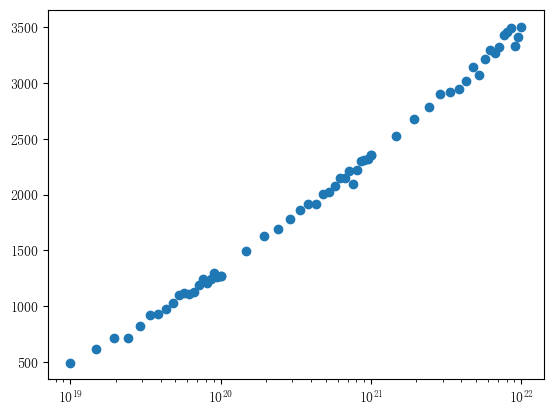

In [519]:
plt.scatter(v_0_t,results_v_01_av3[:,0])
plt.xscale("log")

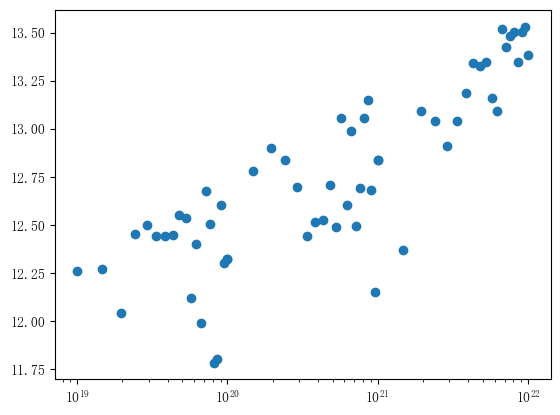

In [520]:
plt.scatter(v_0_t,results_v_01_av3[:,1]*1000)
plt.xscale("log")

In [521]:
global A_v 
A_v = 2.5e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

s_yr = 3600.*24*365
t_end = 4.5e9*s_yr
dt = 1e6*s_yr
t_0 = 0
nt = int((t_end-t_0)/dt)+1
t_t  = np.linspace(t_0 , t_end , nt)

v_0_t1  = np.linspace(1e19,1e20,20)
v_0_t2  = np.linspace(1e20,1e21,20)
v_0_t3  = np.linspace(1e21,1e22,20)
v_0_t = np.hstack((v_0_t1,v_0_t2))
v_0_t = np.hstack((v_0_t,v_0_t3))
j = 0
n = len(v_0_t )

%time results_v_01_av2_5 = Parallel(n_jobs=-1)(delayed(the_v_0_t)(v_0) for v_0 in v_0_t)

CPU times: total: 2.59 s
Wall time: 7min 37s


In [522]:
results_v_01_av2_5 = np.array(results_v_01_av2_5)

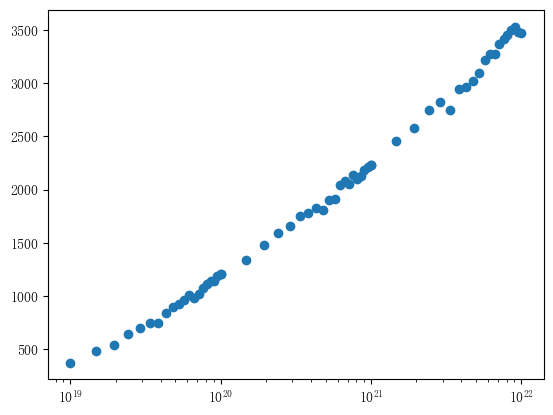

In [523]:
plt.scatter(v_0_t ,results_v_01_av2_5[:,0] )
plt.xscale("log")

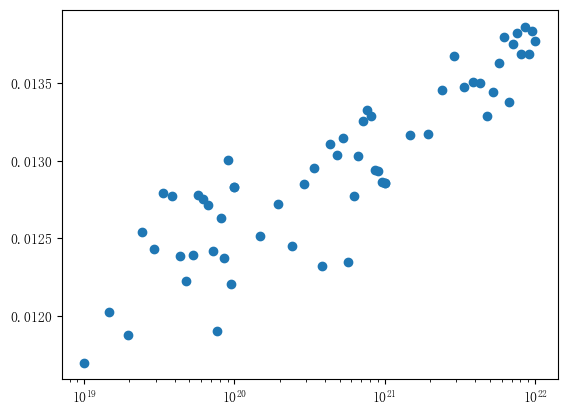

In [524]:
plt.scatter(v_0_t ,results_v_01_av2_5[:,1] )
plt.xscale("log")

# 测试激活能 

In [526]:
def the_A_v(A_v_t ):
    global A_v 
    A_v = A_v_t  
    T_m_initial = 1600
    T_cmb_initial =  2000
    T_time_0 = [T_m_initial , T_cmb_initial] 

    s_yr = 3600.*24*365
    t_end = 4.5e9*s_yr
    dt = 1e6*s_yr
    t_0 = 0
    nt = int((t_end-t_0)/dt)+1
    t_t  = np.linspace(t_0 , t_end , nt)
    params_names = ['Q_rad_man','Q_rad_core','Q_conv','Q_cmb','Q_melt','visc_UM','visc_LM','delta_UM','delta_LM','M','F_C','F_X','F_T','F_S','mass_flux',"L_conv"]
    j_Q_rad_man = 0
    j_Q_rad_core = 1
    j_Q_conv = 2
    j_Q_cmb = 3
    j_Q_melt = 4
    j_visc_UM = 5
    j_visc_LM = 6
    j_delta_UM = 7
    j_delta_LM = 8
    j_M = 9
    j_R_ic = 10
    j_F_c = 11
    j_F_X = 12
    j_F_T = 13
    j_F_S = 14
    j_mass_flux = 15
    j_Lconv = 16
    params = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ,0,0]
    visc_UM_t = np.zeros(nt)
    visc_LM_t = np.zeros(nt)
    delta_UM_t = np.zeros(nt)
    delta_LM_t = np.zeros(nt)
    Q_conv_t = np.zeros(nt)
    Q_cmb_t = np.zeros(nt)
    Q_rad_man_t = np.zeros(nt)
    Q_rad_core_t = np.zeros(nt)
    Q_melt_t = np.zeros(nt)
    M_t = np.zeros(nt)
    R_ic_t = np.zeros(nt)
    F_c_t = np.zeros(nt)
    F_X_t = np.zeros(nt)
    F_T_t = np.zeros(nt)
    F_S_t = np.zeros(nt)
    mass_flux_t = np.zeros(nt)
    Lconv_t =  np.zeros(nt)
    
    r = integrate.ode(Heat_history)
    r.set_integrator('dopri5 ')
    r.set_initial_value(T_time_0, t_t[0])
    r.set_f_params(params)

    plan_them_history = np.zeros((len(t_t),len(T_time_0)))
    idx = 0

    while r.successful() and r.t < t_end:
        start =time.time()
        plan_them_history[idx , :] = r.y
        r.integrate(r.t+dt) 
        params = r.f_params[0]
        visc_UM_t[idx] = params[j_visc_UM]
        visc_LM_t[idx] = params[j_visc_LM]
        delta_UM_t[idx] = params[j_delta_UM]
        delta_LM_t[idx] = params[j_delta_LM]
        Q_conv_t[idx] = params[j_Q_conv]
        Q_cmb_t[idx] = params[j_Q_cmb]
        Q_rad_man_t[idx] = params[j_Q_rad_man]
        Q_rad_core_t[idx] = params[j_Q_rad_core] 
        Q_melt_t[idx] = params[j_Q_melt]
        M_t[idx] =  params[j_M]
        R_ic_t[idx] = params[j_R_ic]
            
        F_c_t[idx] = params[j_F_c]
        F_X_t[idx] = params[j_F_X]
        F_T_t[idx] = params[j_F_T]
        F_S_t[idx] = params[j_F_S]
        mass_flux_t[idx] = params[j_mass_flux]
    
        idx += 1
    
    fin_T_m = plan_them_history[-2,0]
    fin_T_c = plan_them_history[-2,1]
    fin_M_flux = mass_flux_t[-2]
    fin_Tm_flux =  Q_conv_t[-2]+Q_melt_t[-2]
    M_flux_tGa = mass_flux_t[-2000]
    vendtime = foundfirst0(mass_flux_t)
            
    return  vendtime , fin_Tm_flux/(4*np.pi*R**2) 

In [527]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

In [528]:
A_v_t  = np.linspace(2.4e5,4e5,20)

j = 0
n = len(A_v_t )
fin_T_m = np.zeros(n)
fin_T_c = np.zeros(n)
fin_M_flux = np.zeros(n)
fin_Tm_flux = np.zeros(n)
M_flux_tGa = np.zeros(n)

In [529]:
%time results_A_v = Parallel(n_jobs=-1)(delayed(the_A_v)(A_v) for A_v in A_v_t)

CPU times: total: 656 ms
Wall time: 2min 50s


In [530]:
results_A_v = np.array(results_A_v)

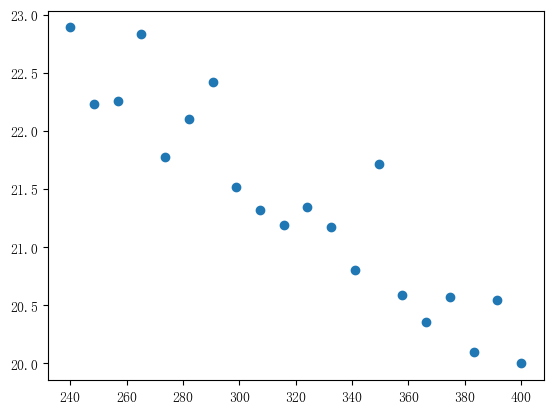

In [531]:
plt.scatter(A_v_t/1e3 ,(4500-results_A_v[:,0])/100)
#plt.xscale("log")


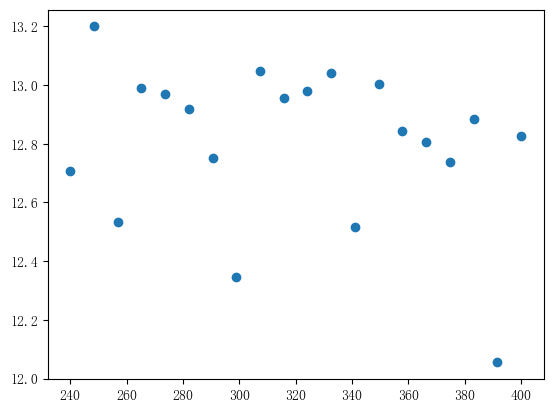

In [532]:
plt.scatter(A_v_t/1e3 ,results_A_v[:,1]*1000)

In [533]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 5e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

In [534]:
A_v_t  = np.linspace(2.4e5,4e5,20)

j = 0
n = len(A_v_t )
fin_T_m = np.zeros(n)
fin_T_c = np.zeros(n)
fin_M_flux = np.zeros(n)
fin_Tm_flux = np.zeros(n)
M_flux_tGa = np.zeros(n)

%time results_A_v_v0521 = Parallel(n_jobs=-1)(delayed(the_A_v)(A_v) for A_v in A_v_t)

CPU times: total: 859 ms
Wall time: 2min 35s


In [535]:
results_A_v_v0521 = np.array(results_A_v_v0521)

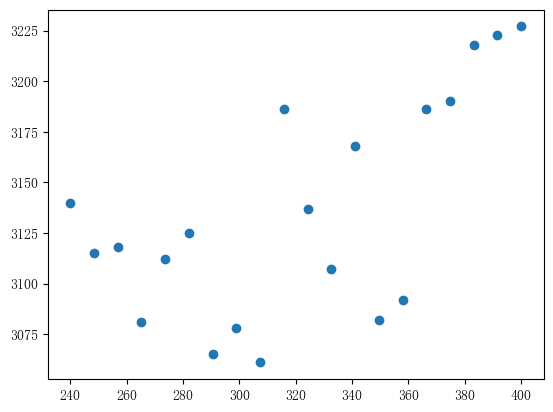

In [536]:
plt.scatter( A_v_t/1e3 ,results_A_v_v0521[:,0] )

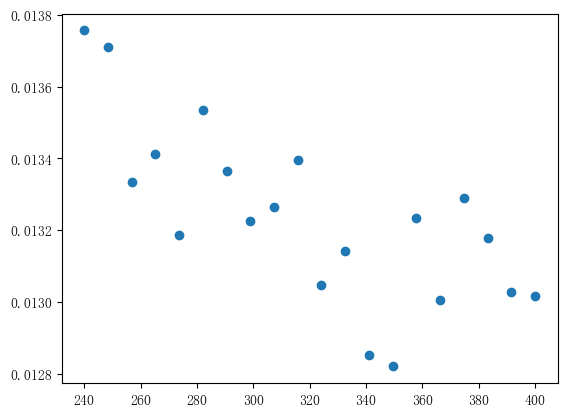

In [537]:
plt.scatter( A_v_t/1e3 ,results_A_v_v0521[:,1] )

# 测试钍含量的影响

In [540]:
def the_rd_man(CTh_in):
    global C_Th_in 
    C_Th_in = CTh_in

    #print(C_Th_in)
    T_m_initial = 1600
    T_cmb_initial =  2000
    T_time_0 = [T_m_initial , T_cmb_initial] 

    s_yr = 3600.*24*365
    t_end = 4.5e9*s_yr
    dt = 1e6*s_yr
    t_0 = 0
    nt = int((t_end-t_0)/dt)+1
    t_t  = np.linspace(t_0 , t_end , nt)
    params_names = ['Q_rad_man','Q_rad_core','Q_conv','Q_cmb','Q_melt','visc_UM','visc_LM','delta_UM','delta_LM','M','F_C','F_X','F_T','F_S','mass_flux',"L_conv"]
    j_Q_rad_man = 0
    j_Q_rad_core = 1
    j_Q_conv = 2
    j_Q_cmb = 3
    j_Q_melt = 4
    j_visc_UM = 5
    j_visc_LM = 6
    j_delta_UM = 7
    j_delta_LM = 8
    j_M = 9
    j_R_ic = 10
    j_F_c = 11
    j_F_X = 12
    j_F_T = 13
    j_F_S = 14
    j_mass_flux = 15
    j_Lconv = 16
    params = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ,0,0]
    visc_UM_t = np.zeros(nt)
    visc_LM_t = np.zeros(nt)
    delta_UM_t = np.zeros(nt)
    delta_LM_t = np.zeros(nt)
    Q_conv_t = np.zeros(nt)
    Q_cmb_t = np.zeros(nt)
    Q_rad_man_t = np.zeros(nt)
    Q_rad_core_t = np.zeros(nt)
    Q_melt_t = np.zeros(nt)
    M_t = np.zeros(nt)
    R_ic_t = np.zeros(nt)
    F_c_t = np.zeros(nt)
    F_X_t = np.zeros(nt)
    F_T_t = np.zeros(nt)
    F_S_t = np.zeros(nt)
    mass_flux_t = np.zeros(nt)
    Lconv_t =  np.zeros(nt)
    
    r = integrate.ode(Heat_history)
    r.set_integrator('dopri5 ')
    r.set_initial_value(T_time_0, t_t[0])
    r.set_f_params(params)

    plan_them_history = np.zeros((len(t_t),len(T_time_0)))
    idx = 0

    while r.successful() and r.t < t_end:
        start =time.time()
        plan_them_history[idx , :] = r.y
        r.integrate(r.t+dt) 
        params = r.f_params[0]
        visc_UM_t[idx] = params[j_visc_UM]
        visc_LM_t[idx] = params[j_visc_LM]
        delta_UM_t[idx] = params[j_delta_UM]
        delta_LM_t[idx] = params[j_delta_LM]
        Q_conv_t[idx] = params[j_Q_conv]
        Q_cmb_t[idx] = params[j_Q_cmb]
        Q_rad_man_t[idx] = params[j_Q_rad_man]
        Q_rad_core_t[idx] = params[j_Q_rad_core] 
        Q_melt_t[idx] = params[j_Q_melt]
        M_t[idx] =  params[j_M]
        R_ic_t[idx] = params[j_R_ic]
            
        F_c_t[idx] = params[j_F_c]
        F_X_t[idx] = params[j_F_X]
        F_T_t[idx] = params[j_F_T]
        F_S_t[idx] = params[j_F_S]
        mass_flux_t[idx] = params[j_mass_flux]
    
        idx += 1
    
    fin_T_m = plan_them_history[-2,0]
    fin_T_c = plan_them_history[-2,1]
    fin_M_flux = mass_flux_t[-2]
    fin_Tm_flux =  Q_conv_t[-2]+Q_melt_t[-2]
    vendtime = foundfirst0(mass_flux_t)
            
    return  vendtime , fin_Tm_flux/(4*np.pi*R**2) 

In [541]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

In [542]:
CTh_initial_t = np.linspace(33.9e-9,150e-9,40)

In [543]:
%time results_rad = Parallel(n_jobs=-1)(delayed(the_rd_man)(CTh_in) for CTh_in in CTh_initial_t)

CPU times: total: 1.61 s
Wall time: 39min 25s


In [544]:
results_rad  = np.array(results_rad )

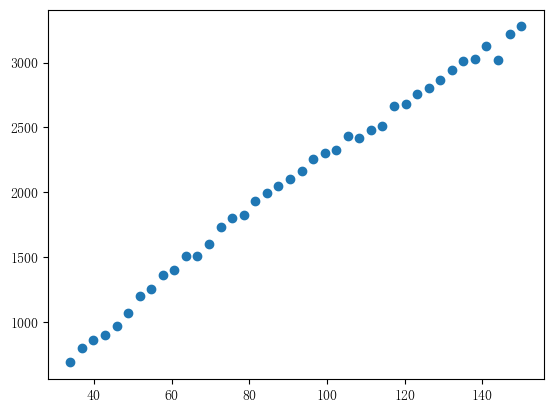

In [545]:
plt.scatter(CTh_initial_t/1e-9  ,results_rad[:,0])
#plt.xscale("log")

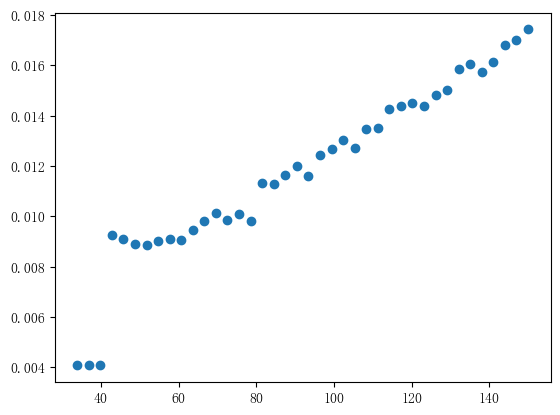

In [546]:
plt.scatter(CTh_initial_t/1e-9  ,results_rad[:,1])
#plt.xscale("log")

In [547]:
global A_v 
A_v = 2.5e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

CTh_initial_t = np.linspace(33.9e-9,150e-9,40)
%time results_rad_av25_v121 = Parallel(n_jobs=-1)(delayed(the_rd_man)(CTh_in) for CTh_in in CTh_initial_t)

D:\annaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: total: 1.48 s
Wall time: 5min 30s


In [548]:
results_rad_av25_v121 = np.array(results_rad_av25_v121)

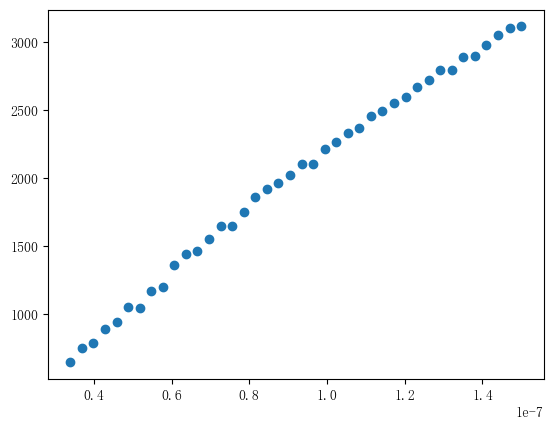

In [549]:
plt.scatter(CTh_initial_t ,results_rad_av25_v121[:,0] )

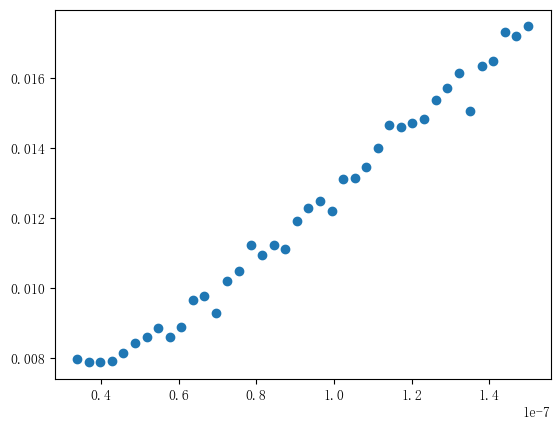

In [550]:
plt.scatter(CTh_initial_t ,results_rad_av25_v121[:,1] )

In [551]:
global A_v 
A_v = 2.5e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 5e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

CTh_initial_t = np.linspace(33.9e-9,150e-9,40)
%time results_rad_av25_v521 = Parallel(n_jobs=-1)(delayed(the_rd_man)(CTh_in) for CTh_in in CTh_initial_t)

CPU times: total: 1.56 s
Wall time: 5min 44s


In [552]:
results_rad_av25_v521 = np.array(results_rad_av25_v521)

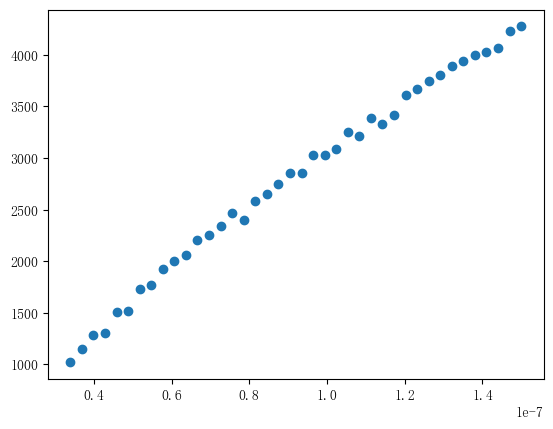

In [553]:
plt.scatter(CTh_initial_t ,results_rad_av25_v521[:,0])

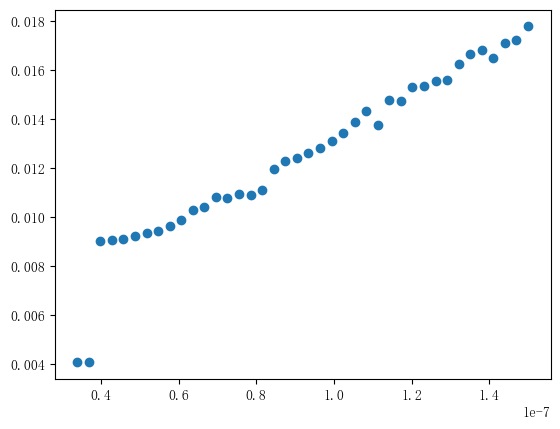

In [554]:
plt.scatter(CTh_initial_t ,results_rad_av25_v521[:,1])

In [555]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

CTh_initial_t = np.linspace(33.9e-9,150e-9,40)
%time results_rad_av25_v521 = Parallel(n_jobs=-1)(delayed(the_rd_man)(CTh_in) for CTh_in in CTh_initial_t)

CPU times: total: 1.72 s
Wall time: 5min 46s


In [556]:
results_rad_av25_v521 = np.array(results_rad_av25_v521)

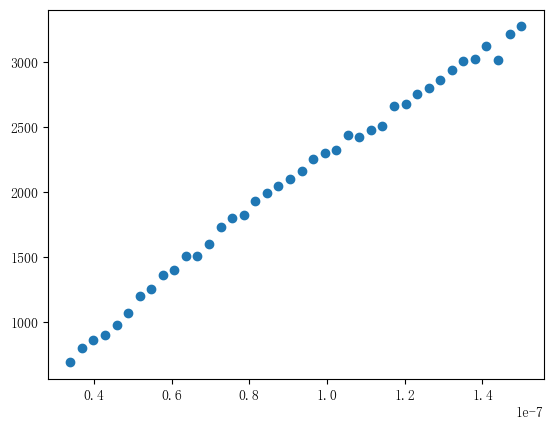

In [557]:
plt.scatter(CTh_initial_t,results_rad_av25_v521[:,0])

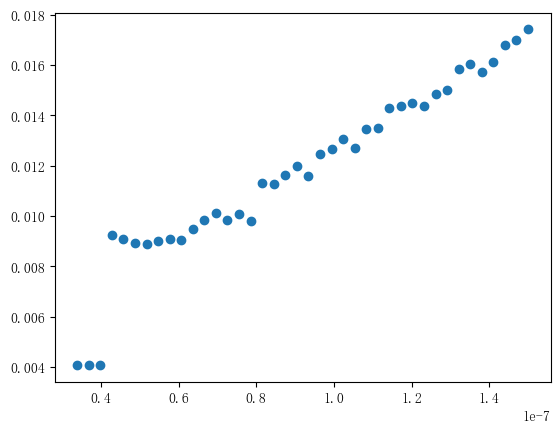

In [558]:
plt.scatter(CTh_initial_t,results_rad_av25_v521[:,1])

In [559]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 5e20#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

CTh_initial_t = np.linspace(33.9e-9,150e-9,40)
%time results_rad_av3e5_v520 = Parallel(n_jobs=-1)(delayed(the_rd_man)(CTh_in) for CTh_in in CTh_initial_t)

CPU times: total: 1.44 s
Wall time: 5min 49s


In [560]:
results_rad_av3e5_v520 = np.array(results_rad_av3e5_v520)

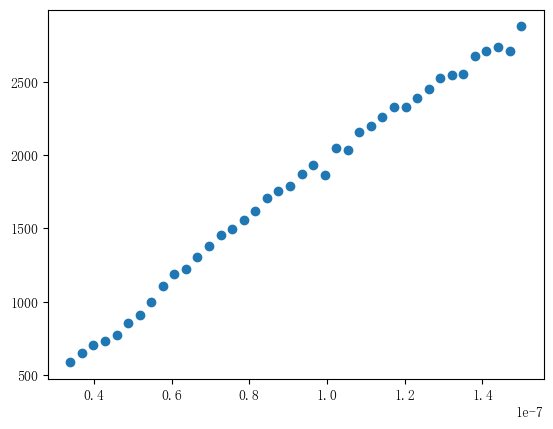

In [561]:
plt.scatter(CTh_initial_t ,results_rad_av3e5_v520[:,0] )

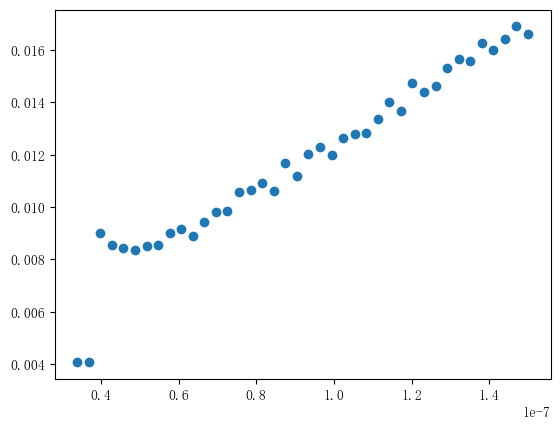

In [562]:
plt.scatter(CTh_initial_t ,results_rad_av3e5_v520[:,1] )

In [563]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 5e19#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

CTh_initial_t = np.linspace(33.9e-9,150e-9,40)
%time results_rad_av3e5_v519 = Parallel(n_jobs=-1)(delayed(the_rd_man)(CTh_in) for CTh_in in CTh_initial_t)

CPU times: total: 1.58 s
Wall time: 6min 9s


In [564]:
results_rad_av3e5_v519 = np.array(results_rad_av3e5_v519)

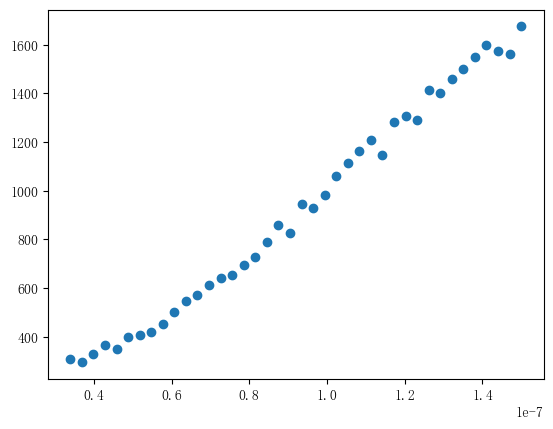

In [565]:
plt.scatter(CTh_initial_t ,results_rad_av3e5_v519[:,0] )

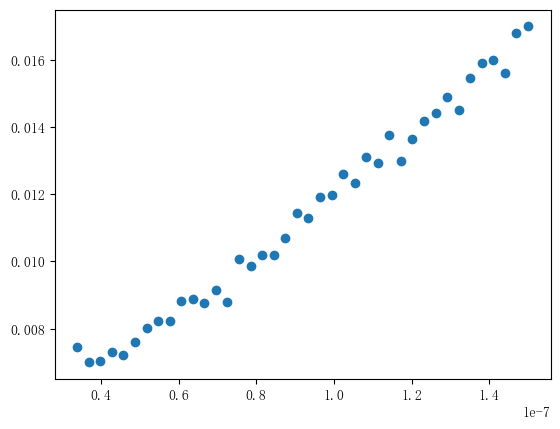

In [566]:
plt.scatter(CTh_initial_t ,results_rad_av3e5_v519[:,1] )

# 测试喷发率

In [570]:
def the_epsilon(epsilon_e_t):
    global epsilon_e
    epsilon_e = epsilon_e_t#喷发率

    T_m_initial = 1600
    T_cmb_initial =  2000
    T_time_0 = [T_m_initial , T_cmb_initial] 

    s_yr = 3600.*24*365
    t_end = 4.5e9*s_yr
    dt = 1e6*s_yr
    t_0 = 0
    nt = int((t_end-t_0)/dt)+1
    t_t  = np.linspace(t_0 , t_end , nt)
    params_names = ['Q_rad_man','Q_rad_core','Q_conv','Q_cmb','Q_melt','visc_UM','visc_LM','delta_UM','delta_LM','M','F_C','F_X','F_T','F_S','mass_flux',"L_conv"]
    j_Q_rad_man = 0
    j_Q_rad_core = 1
    j_Q_conv = 2
    j_Q_cmb = 3
    j_Q_melt = 4
    j_visc_UM = 5
    j_visc_LM = 6
    j_delta_UM = 7
    j_delta_LM = 8
    j_M = 9
    j_R_ic = 10
    j_F_c = 11
    j_F_X = 12
    j_F_T = 13
    j_F_S = 14
    j_mass_flux = 15
    j_Lconv = 16
    params = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ,0,0]
    visc_UM_t = np.zeros(nt)
    visc_LM_t = np.zeros(nt)
    delta_UM_t = np.zeros(nt)
    delta_LM_t = np.zeros(nt)
    Q_conv_t = np.zeros(nt)
    Q_cmb_t = np.zeros(nt)
    Q_rad_man_t = np.zeros(nt)
    Q_rad_core_t = np.zeros(nt)
    Q_melt_t = np.zeros(nt)
    M_t = np.zeros(nt)
    R_ic_t = np.zeros(nt)
    F_c_t = np.zeros(nt)
    F_X_t = np.zeros(nt)
    F_T_t = np.zeros(nt)
    F_S_t = np.zeros(nt)
    mass_flux_t = np.zeros(nt)
    Lconv_t =  np.zeros(nt)
    
    r = integrate.ode(Heat_history)
    r.set_integrator('dopri5 ')
    r.set_initial_value(T_time_0, t_t[0])
    r.set_f_params(params)

    plan_them_history = np.zeros((len(t_t),len(T_time_0)))
    idx = 0

    while r.successful() and r.t < t_end:
        start =time.time()
        plan_them_history[idx , :] = r.y
        r.integrate(r.t+dt) 
        params = r.f_params[0]
        visc_UM_t[idx] = params[j_visc_UM]
        visc_LM_t[idx] = params[j_visc_LM]
        delta_UM_t[idx] = params[j_delta_UM]
        delta_LM_t[idx] = params[j_delta_LM]
        Q_conv_t[idx] = params[j_Q_conv]
        Q_cmb_t[idx] = params[j_Q_cmb]
        Q_rad_man_t[idx] = params[j_Q_rad_man]
        Q_rad_core_t[idx] = params[j_Q_rad_core] 
        Q_melt_t[idx] = params[j_Q_melt]
        M_t[idx] =  params[j_M]
        R_ic_t[idx] = params[j_R_ic]
            
        F_c_t[idx] = params[j_F_c]
        F_X_t[idx] = params[j_F_X]
        F_T_t[idx] = params[j_F_T]
        F_S_t[idx] = params[j_F_S]
        mass_flux_t[idx] = params[j_mass_flux]
    
        idx += 1
    
    fin_T_m = plan_them_history[-2,0]
    fin_T_c = plan_them_history[-2,1]
    fin_M_flux = mass_flux_t[-2]
    fin_Tm_flux =  Q_conv_t[-2]+Q_melt_t[-2]
    vendtime = foundfirst0(mass_flux_t)
            
    return  vendtime , fin_Tm_flux/(4*np.pi*R**2) 

In [571]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

In [572]:
epsilon_e_t = np.linspace(0,1,20)

In [573]:
%time results_epsilon_3e5 = Parallel(n_jobs=-1)(delayed(the_epsilon)(epsilon) for epsilon in epsilon_e_t)

CPU times: total: 906 ms
Wall time: 2min 57s


In [574]:
results_epsilon_3e5 = np.array(results_epsilon_3e5 )

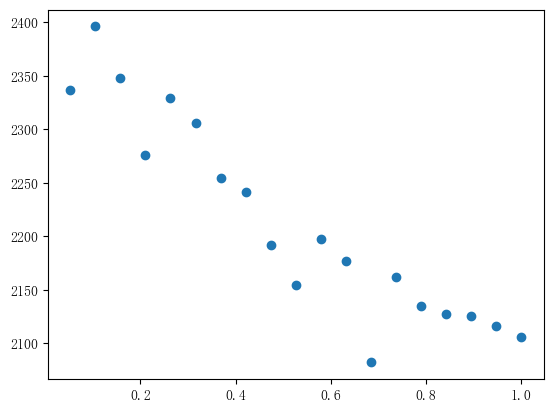

In [575]:
plt.scatter(epsilon_e_t[1:]  ,results_epsilon_3e5[1:,0])

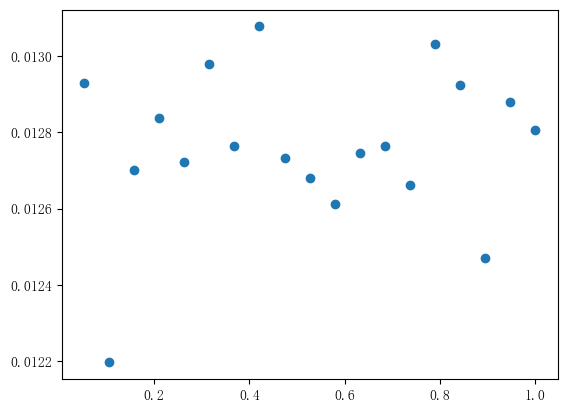

In [576]:
plt.scatter(epsilon_e_t[1:]  ,results_epsilon_3e5[1:,1])  

In [577]:
global A_v 
A_v = 3e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 5e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

epsilon_e_t = np.linspace(0,1,20)
%time results_epsilon_av3e5_v521 = Parallel(n_jobs=-1)(delayed(the_epsilon)(epsilon) for epsilon in epsilon_e_t)

CPU times: total: 922 ms
Wall time: 2min 55s


In [578]:
results_epsilon_av3e5_v521  = np.array(results_epsilon_av3e5_v521 )

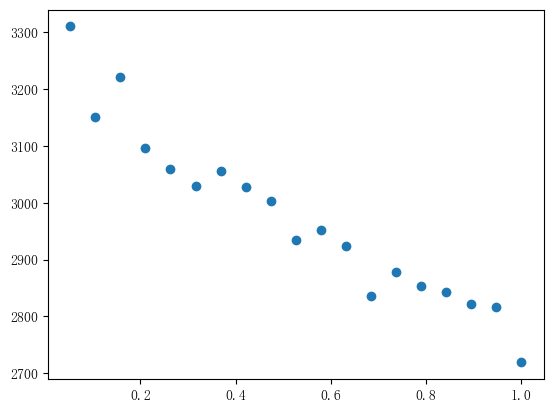

In [579]:
plt.scatter(epsilon_e_t[1:] ,results_epsilon_av3e5_v521[1:,0] )

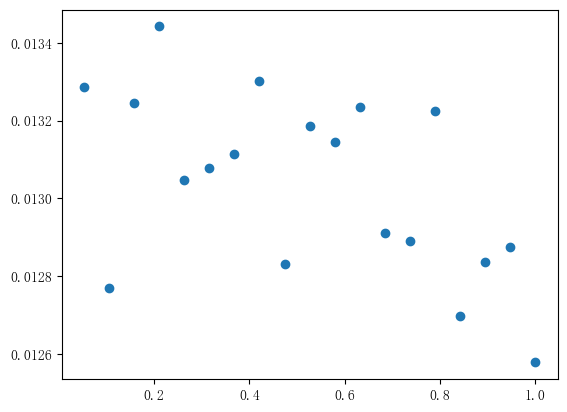

In [580]:
plt.scatter(epsilon_e_t[1:] ,results_epsilon_av3e5_v521[1:,1] )

In [581]:
global A_v 
A_v = 2.5e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 5e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

epsilon_e_t = np.linspace(0,1,20)
%time results_epsilon_av25e5_v521 = Parallel(n_jobs=-1)(delayed(the_epsilon)(epsilon) for epsilon in epsilon_e_t)

CPU times: total: 781 ms
Wall time: 2min 43s


In [582]:
results_epsilon_av25e5_v521 = np.array(results_epsilon_av25e5_v521)

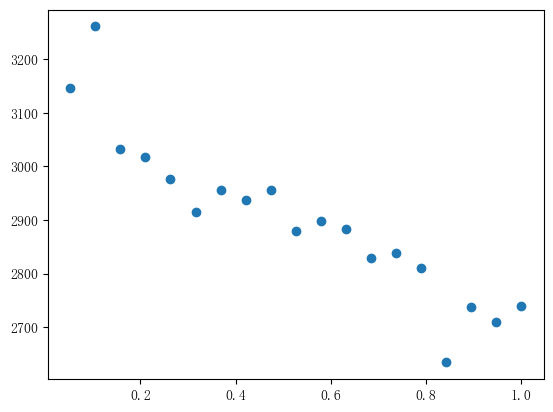

In [583]:
plt.scatter(epsilon_e_t[1:] ,results_epsilon_av25e5_v521[1:,0] )

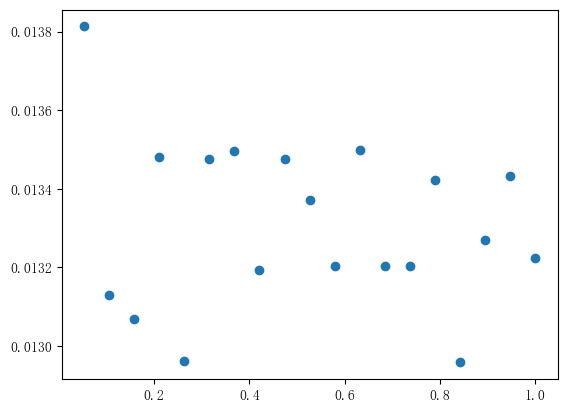

In [584]:
plt.scatter(epsilon_e_t[1:] ,results_epsilon_av25e5_v521[1:,1] )

In [585]:
global A_v 
A_v = 2.5e5
global epsilon_e
epsilon_e = 0.2 #喷发率
global v_0 
v_0 = 1e21#月幔参考粘度|
     #上下地幔的粘度差， 0——20自由选择
global C_Th_in 
C_Th_in = 1.0205314067553884e-07

epsilon_e_t = np.linspace(0,1,20)
%time results_epsilon_av25e5_v121 = Parallel(n_jobs=-1)(delayed(the_epsilon)(epsilon) for epsilon in epsilon_e_t)

CPU times: total: 703 ms
Wall time: 2min 44s


In [586]:
results_epsilon_av25e5_v121 = np.array(results_epsilon_av25e5_v121)

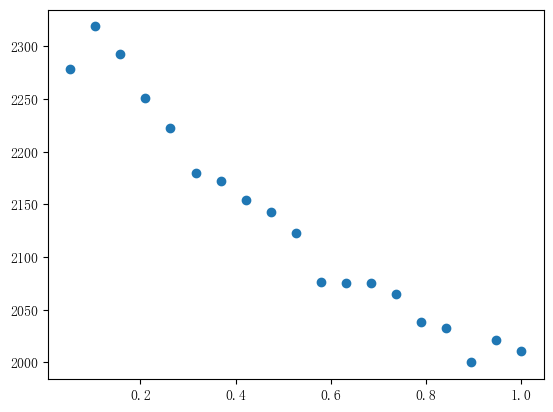

In [587]:
plt.scatter(epsilon_e_t[1:] ,results_epsilon_av25e5_v121[1:,0] )

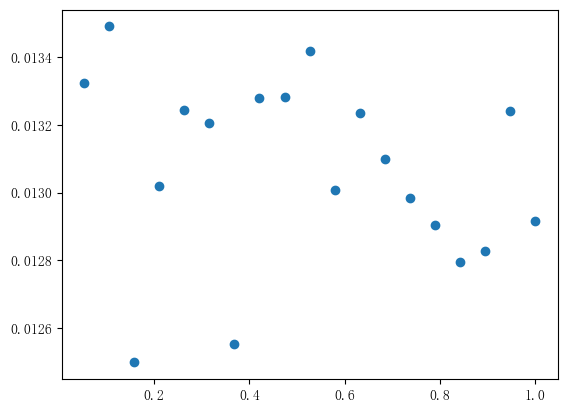

In [588]:
plt.scatter(epsilon_e_t[1:] ,results_epsilon_av25e5_v121[1:,1] )

In [589]:
s = pd.concat([
                  pd.DataFrame({'0_v_0_t':v_0_t}),
                  pd.DataFrame({'1_A_v_t':A_v_t}), 
                  pd.DataFrame({'2_CTh_initial_t':CTh_initial_t}),
                  pd.DataFrame({'3_epsilon_e_t':epsilon_e_t}),
                  
                  pd.DataFrame({'4_end_tim_results_v_01_av3':results_v_01_av3[:,0]}),
                  pd.DataFrame({'5_heatflux_results_v_01_av3':results_v_01_av3[:,1]}),
                  pd.DataFrame({'6_end_tim_results_v_01_av2_5':results_v_01_av2_5[:,0]}),
                  pd.DataFrame({'7_heatflux_results_v_01_av2_5':results_v_01_av2_5[:,1]}),

                  pd.DataFrame({'8_end_tim_results_results_A_v_v0121':results_A_v[:,0]}),
                  pd.DataFrame({'9_heatflux_results_results_A_v_v0121':results_A_v[:,1]}),
                  pd.DataFrame({'10_end_tim_results_results_A_v_v0521':results_A_v_v0521[:,0]}),
                  pd.DataFrame({'11_heatflux_results_results_A_v_v0521':results_A_v_v0521[:,1]}),

                  pd.DataFrame({'12_end_tim_resultsrad_3e5_121':results_rad[:,0]}),
                  pd.DataFrame({'13_heatflux_resultsrad_3e5_121':results_rad[:,1]}),
                  pd.DataFrame({'14_end_tim_results_rad_av25_v121':results_rad_av25_v121[:,0]}),
                  pd.DataFrame({'15_heatflux_results_rad_av25_v121':results_rad_av25_v121[:,1]}),
                  pd.DataFrame({'16_end_tim_results_rad_av25_v521':results_rad_av25_v521[:,0]}),
                  pd.DataFrame({'17_heatflux_results_rad_av25_v521':results_rad_av25_v521[:,1]}),
                  pd.DataFrame({'18_end_tim_results_rad_av3e5_v520':results_rad_av3e5_v520[:,0]}),    
                  pd.DataFrame({'19_heatflux_results_rad_av3e5_v520':results_rad_av3e5_v520[:,1]}),
                  pd.DataFrame({'20_end_tim_results_rad_av3e5_v519 ':results_rad_av3e5_v519[:,0]}),    
                  pd.DataFrame({'21_heatflux_results_rad_av3e5_v519 ':results_rad_av3e5_v519[:,1]}),

    
    
                  
                  pd.DataFrame({'22_end_tim_results_epsilon_3e5_121':results_epsilon_3e5[:,0]}),
                  pd.DataFrame({'23_heatflux_results_epsilon_3e5_121':results_epsilon_3e5[:,1]}),
                  pd.DataFrame({'24_end_tim_results_epsilon_av3e5_v521 ':results_epsilon_av3e5_v521 [:,0]}),
                  pd.DataFrame({'25_heatflux_results_epsilon_av3e5_v521 ':results_epsilon_av3e5_v521 [:,1]}),
                  pd.DataFrame({'26_end_tim_results_epsilon_av25e5_v521 ':results_epsilon_av25e5_v521[:,0]}),
                  pd.DataFrame({'27_heatflux_results_epsilon_av25e5_v521 ':results_epsilon_av25e5_v521[:,1]}),
                  pd.DataFrame({'28_end_tim_results_epsilon_av25e5_v121 ':results_epsilon_av25e5_v121 [:,0]}),
                  pd.DataFrame({'29_heatflux_results_epsilon_av25e5_v121  ':results_epsilon_av25e5_v121 [:,1]}),

    
    
                 
                

   
] 
              ,axis=1)

s.to_csv('results.csv')